# Setup

## Import relevant Modules

In [1]:
%matplotlib inline

import pandas as pd
import datetime 
import numpy as np
import glob
import os
import getpass
import sqlalchemy
#import geoalchemy2
import sys
import itertools
#from shutil import copyfile
import platform

import seaborn as sns

import scipy

import folium

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot,iplot_mpl,plot_mpl
import plotly.graph_objs as go

init_notebook_mode(connected=True)

import wellapplication as wa

import geostatsmodels
import scipy.stats

import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm

from scipy.interpolate import griddata
import cartopy
import cartopy.crs as ccrs

import geopandas
from shapely.geometry import Point

import verde as vd

rcParams['figure.figsize'] = 15, 15
rcParams['pdf.fonttype'] = 42

In [4]:
#llpath = "E:/My Drive/Python/Pycharm/loggerloader/"
llpath = "G:/My Drive/Python/Pycharm/loggerloader/"
sys.path.append(llpath)
import loggerloader as ll

## Connect to GWL Database

In [37]:
import importlib.util
spec = importlib.util.spec_from_file_location("dbconnect", "G:/My Drive/Python/dbconnect.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)
engine = dbconnect.postconn(port=5433)
engine2 = dbconnect.postconn_ugs()

## Define Custom Functions

In [6]:
def label_utm_grid():
    ''' Labels Map with UTM Grid Warning: should only use with small area UTM maps 
    sourc: https://github.com/SciTools/cartopy/issues/491'''
    ax = plt.gca()    
    for val,label in zip(ax.get_xticks(), ax.get_xticklabels()):
        label.set_text(str(val))
        label.set_position((val,0))  

    for val,label in zip(ax.get_yticks(), ax.get_yticklabels()):   
        label.set_text(str(val))
        label.set_position((0,val))  

    plt.tick_params(bottom=True,top=True,left=True,right=True,
            labelbottom=True,labeltop=False,labelleft=True,labelright=False)

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    plt.grid(True)

In [7]:
def make_geojson(df, name, xcord='UTM_X', ycord='UTM_Y', 
                 epsg = '26912', savedir = "G:/My Drive/WORK/Leland_Harris/"):
    crs = {'init': 'epsg:{:}'.format(epsg)}
    geometry = [Point(xy) for xy in zip(df[xcord], df[ycord])]
    gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)
    gdf.to_file(savedir + "{:}.geojson".format(name), driver='GeoJSON')
    

# Import Bathymetry Data

The `BathymetryPointDepths.xlsx` file contains modeled bathymetry for more than 3000 points at different times.

In [124]:
file = "G:/My Drive/WORK/Leland_Harris/BathymetryPointDepths.xlsx"
xl = pd.ExcelFile(file)

sht = {}
sht2 = {}
for sheet in xl.sheet_names[1:-3]:
    sht[sheet] = xl.parse(sheet, index_col = 0).sort_index()
    sht2[sheet] = xl.parse(sheet, index_col = 0).sort_index()['OWD']
bath = xl.parse("LelandBathymetry",index_col = 0)

shts = pd.concat(sht,axis=0)
sths2 = pd.concat(sht2,axis=1)
#shts = pd.concat([shts,pond],axis=1)

In [126]:
months_cols = ['April13', 'Aug13', 'Aug14', 'Feb13', 'Jan13', 'July13', 'July14', 'June13', 'May13',
               'May14', 'Nov12', 'Oct13', 'Oct2012', 'Sept13']
owd = pd.concat([bath,sths2],axis=1)
owd = owd.drop(['Point'],axis=1)
owd['mean_owd'] = owd.loc[:,months_cols].mean(axis=1)
owd['std_owd'] = owd.loc[:,months_cols].std(axis=1)
owd['median_owd'] = owd.loc[:,months_cols].median(axis=1)

In [127]:
geometry = [Point(xy) for xy in zip(owd.UTM_X, owd.UTM_Y)]
#df = df.drop(['Lon', 'Lat'], axis=1)
crs = {'init': 'epsg:26912'} # NAD83 / UTM zone 12N 
owd_gdf = geopandas.GeoDataFrame(owd, crs=crs, geometry=geometry)

In [128]:
bathmatch = xl.parse('bathmatch', index_col = 0)

In [129]:
smareas = ['SW Bulrush Marsh','NE Bulrush Marsh',
           'Chub Haven Marsh','Big Ephemeral Pond',
           'Cattail Marsh','Site 7','Teal Pond','Lost Springs',
           'NW Bulrush Marsh','Isosceles Pond','Cowtrap Springs','Mystery Springs']

In [190]:
owdshts = shts.reset_index().rename(columns={'level_0':'Date'}).drop(['Water_Body'],axis=1)

def parsedate(x):
    modict = {'April13':'2013-04-04', 'Aug13': '2013-08-21', 'Aug14': '2014-08-20', 
          'Feb13':'2013-02-18', 'Jan13':'2013-01-05', 'July13': '2013-07-26', 'July14': '2014-07-26', 
          'June13': '2013-06-20', 'May13': '2013-05-02', 'May14': '2014-05-10', 'Nov12': '2012-11-14', 
          'Oct13':'2013-10-21', 'Oct2012': '2012-10-05', 'Sept13':'2013-09-13'}

    x = modict.get(x)
    da = pd.to_datetime(x,format='%Y-%m-%d')
    return da

bathsub = bath[['theor_elev', 'LiDAR_m','close_theor', 'Point', 'Notes', 'obsid', 'VegHeight', 'bod_simp','Water_Body']]
owdshts['BathDate']= owdshts['Date'].apply(lambda x: parsedate(x),1)
owdshts = owdshts.drop(['Date'],axis=1)
batha = pd.merge(owdshts, bathsub.reset_index(),on='Ob_ID',how='left')

In [191]:
owd_gdf.to_file("G:/My Drive/WORK/Leland_Harris/bathymetry.geojson", driver='GeoJSON')
#owd_gdf.to_file("G:/My Drive/WORK/Leland_Harris/bathymetry.shp")

In [192]:
owd_gdf.columns

Index(['UTM_X', 'UTM_Y', 'OWD', 'TWD', 'FSD', 'theor_elev', 'LiDAR_m',
       'close_theor', 'Water_Body', 'BathDate', 'Notes', 'obsid', 'TARGET_FID',
       'Point.1', 'VegHeight', 'bod_simp', 'April13', 'Aug13', 'Aug14',
       'Feb13', 'Jan13', 'July13', 'July14', 'June13', 'May13', 'May14',
       'Nov12', 'Oct13', 'Oct2012', 'Sept13', 'mean_owd', 'std_owd',
       'median_owd', 'geometry'],
      dtype='object')

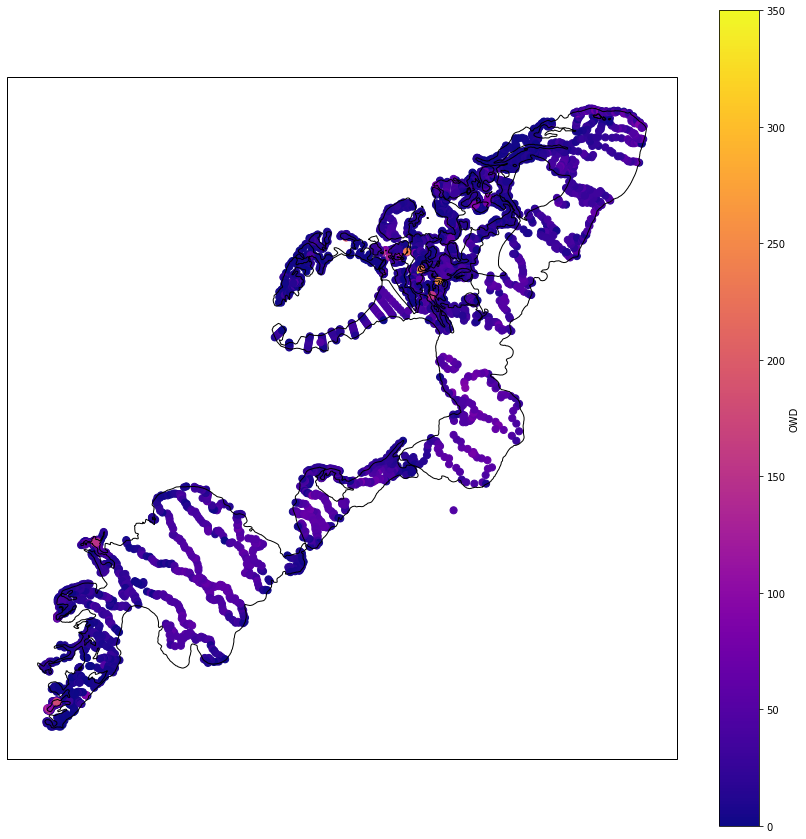

In [193]:
plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.UTM(12))
plt.scatter(
    owd_gdf['UTM_X'], owd_gdf['UTM_Y'],
    c=owd_gdf['OWD'],
    s=50, cmap="plasma",
    transform=ccrs.UTM(12))

shape = geopandas.read_file("E:/PROJECTS/Leland_Harris/CSF Analysis/Data/Wetland_Outline.shp")

shape.plot(ax=ax, color='none', edgecolor='black')


plt.colorbar().set_label("OWD")


plt.show()

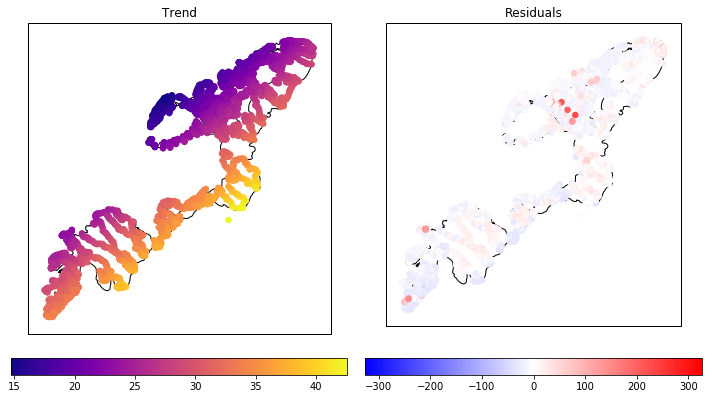

In [14]:
coordinates = (owd_gdf['UTM_X'], owd_gdf['UTM_Y'])
trend = vd.Trend(degree=1).fit(coordinates, owd_gdf['OWD'])
print(trend.coef_)

trend_values = trend.predict(coordinates)
residuals = owd_gdf['OWD'] - trend_values

shape = geopandas.read_file("E:/PROJECTS/Leland_Harris/CSF Analysis/Data/Wetland_Outline.shp")

fig, axes = plt.subplots(
    1, 2, figsize=(10, 6), subplot_kw=dict(projection=ccrs.UTM(12))
)

ax = axes[0]
ax.set_title("Trend")
shape.plot(ax=axes[0], color='none', edgecolor='black')

tmp = ax.scatter(
    owd_gdf['UTM_X'],
    owd_gdf['UTM_Y'],
    c=trend_values,
    s=30,
    cmap="plasma",
    transform=ccrs.UTM(12),
)
plt.colorbar(tmp, ax=ax, orientation="horizontal", pad=0.06)


ax = axes[1]
ax.set_title("Residuals")
shape.plot(ax=axes[1], color='none', edgecolor='black')
maxabs = vd.maxabs(residuals)
tmp = ax.scatter(
    owd_gdf['UTM_X'],
    owd_gdf['UTM_Y'],
    c=residuals,
    s=30,
    cmap="bwr",
    vmin=-maxabs,
    vmax=maxabs,
    transform=ccrs.UTM(12),
)
plt.colorbar(tmp, ax=ax, orientation="horizontal", pad=0.08)

plt.tight_layout()
plt.show()

In [128]:
owd

UTM_X      UTM_Y   OWD   TWD    FSD                 Water_Body  \
Ob_ID                                                                      
1      251997.0  4382919.0  42.0  66.0  156.0              Gradient Pond   
2      251998.0  4382918.0   0.0   0.0    0.0              Gradient Pond   
3      251999.0  4382916.0  25.0  26.0   28.0              Gradient Pond   
4      251999.0  4382915.0  12.0  36.0   37.0              Gradient Pond   
5      252000.0  4382913.0  16.0  40.0   46.0              Gradient Pond   
...         ...        ...   ...   ...    ...                        ...   
3848   251771.0  4382824.0  27.0  27.0   28.0  Pool near Posthole Spring   
3849   251055.0  4381908.0  37.0  38.0   74.0              Slough Spring   
3850   251060.0  4381908.0  14.0  15.0   15.0              Slough Spring   
3851   251071.0  4381910.0   7.0   8.0   10.0              Slough Spring   
3852   251040.0  4381897.0  20.0  20.0   20.0              Slough Spring   

        BathDate                                              Notes  Oct2012  \
Ob_ID                                                                          
1     2013-04-16  Deep springs at 251999 4382920 & others at 251...     36.3   
2     2013-04-16        Dry land about 3 cm higher than water level      0.0   
3     2013-04-16  pH=8.32, Conductivity=562 uS, & Tw=12.7 C near...     19.3   
4     2013-04-16                     Least Chub & Utah Chub present      6.3   
5     2013-04-16                                                NaN     10.3   
...          ...                                                ...      ...   
3848  2014-05-07                                                NaN     23.3   
3849  2014-05-07                                                NaN     36.5   
3850  2014-05-07                                                NaN     13.5   
3851  2014-05-07                                                NaN      6.5   
3852  2014-05-07                                                NaN     19.5   

       Nov12  ...  Aug13  Sept13  Oct13  May14  July14  Aug14   mean_owd  \
Ob_ID         ...                                                          
1       41.0  ...   37.2    40.2   42.0   43.2    35.1   37.9  40.014286   
2        0.0  ...    0.0     0.0    0.0    0.0     0.0    0.0   0.178571   
3       24.0  ...   20.2    23.2   25.0   26.2    18.1   20.9  23.014286   
4       11.0  ...    7.2    10.2   12.0   13.2     5.1    7.9  10.014286   
5       15.0  ...   11.2    14.2   16.0   17.2     9.1   11.9  14.014286   
...      ...  ...    ...     ...    ...    ...     ...    ...        ...   
3848    28.1  ...   13.5    20.0   22.5   25.0    14.0   17.0  23.192857   
3849    40.3  ...   22.1    33.7   36.6   47.3    22.1   21.3  36.057143   
3850    17.3  ...    0.0    10.7   13.6   24.3     0.0    0.0  13.321429   
3851    10.3  ...    0.0     3.7    6.6   17.3     0.0    0.0   8.321429   
3852    23.3  ...    5.1    16.7   19.6   30.3     5.1    4.3  19.057143   

         std_owd  median_owd                geometry  
Ob_ID                                                 
1       3.712734       40.60  POINT (251997 4382919)  
2       0.668153        0.00  POINT (251998 4382918)  
3       3.712734       23.60  POINT (251999 4382916)  
4       3.712734       10.60  POINT (251999 4382915)  
5       3.712734       14.60  POINT (252000 4382913)  
...          ...         ...                     ...  
3848    8.099807       22.90  POINT (251771 4382824)  
3849   11.735201       36.55  POINT (251055 4381908)  
3850   11.395490       13.55  POINT (251060 4381908)  
3851    9.123695        6.55  POINT (251071 4381910)  
3852   11.735201       19.55  POINT (251040 4381897)  

[3852 rows x 26 columns]

# Interpolate Bathymetry Data

https://www.fatiando.org/verde/dev/tutorials/trends.html

[ 3.89477845e+03  5.28066985e-04 -5.86543714e-04]
Highest score: 0.5806781600747987
Best damping: None
Best mindist: 45


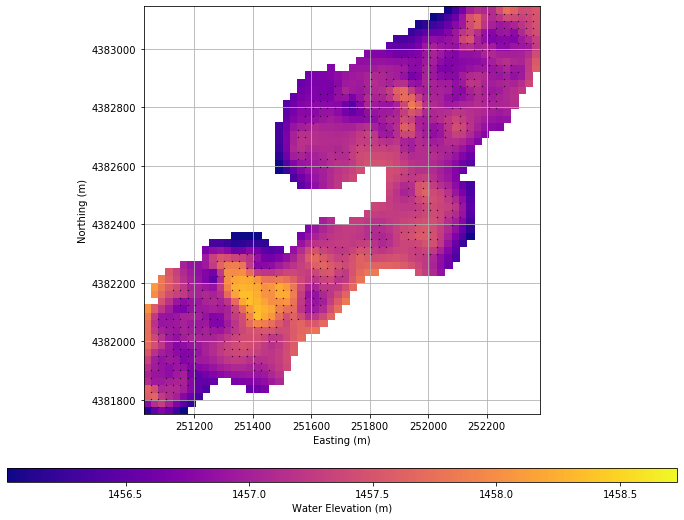

In [356]:
def getz(x,y,grid_x,grid_y,grid_z0,gridspacex,gridspacey,xmin,ymin):
    xi = int(round((x-xmin)/gridspacex)-0.5)
    yi = int(round((y-ymin)/gridspacey)-0.5)
    gx = grid_x[xi][0]
    gy = grid_y[yi][0]
    gz = grid_z0[xi,yi]
    return gz


batha = pd.merge(owdshts, bathsub.reset_index(),on='Ob_ID',how='left')
batha['bath_wl_elev'] = batha['LiDAR_m'] + batha['BathOWD']/100.
batha['monthyr'] = batha['BathDate'].apply(lambda x: datetime.datetime.strftime(x,"%Y%m"),1)
batha = batha.set_index(['monthyr','Ob_ID'])
belev = batha[(batha.index.get_level_values(0)=='201305')]
belev = belev.dropna(subset=['UTM_X','UTM_Y','bath_wl_elev'],how='any')
belev = belev[belev['UTM_X']>230000]
belev = belev[(belev['bath_wl_elev']<1458.75)&(belev['bath_wl_elev']>1456)]
month = '201305'

data = belev
region = vd.get_region((data.UTM_X, data.UTM_Y))
projection = ccrs.UTM(12)
spacing = 20

coordinates = (data.UTM_X, data.UTM_Y)
trend = vd.Trend(degree=1).fit(coordinates, data['bath_wl_elev'])
print(trend.coef_)

trend_values = trend.predict(coordinates)
residuals = data['bath_wl_elev'] - trend_values
tndgrd = trend.grid(region=region, 
                    spacing=spacing, 
                    dims=["UTM_Y", "UTM_X"],  
                    data_names=['bath_wl_elev'])

reducer = vd.BlockReduce(reduction=np.median, spacing=spacing, center_coordinates=True)
proj_coords, bathymetry = reducer.filter((data.UTM_X, data.UTM_Y), residuals)

train, test = vd.train_test_split(proj_coords, bathymetry, test_size=0.3, random_state=0)

spline = vd.SplineCV(dampings=[None, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
                     mindists=[10, 40, 45, 50, 55, 60, 65, 70, 100, 110, 150])

spline.fit(proj_coords, bathymetry)

print("Highest score:", spline.scores_.max())
print("Best damping:", spline.damping_)
print("Best mindist:", spline.mindist_)

grid = spline.grid(region=region, 
                   spacing=spacing, 
                   dims=["UTM_Y", "UTM_X"], 
                   data_names=['bath_wl_elev'])

mask = vd.distance_mask((data.UTM_X, data.UTM_Y), 
                        maxdist=3 * spacing, 
                        coordinates=vd.grid_coordinates(region, spacing=spacing))

grid = grid.where(mask)
tndgrd = tndgrd.where(mask)

fingrd = grid + tndgrd

plt.figure(figsize=(12, 10))

# Plot the gridded bathymetry
pc = fingrd['bath_wl_elev'].plot.pcolormesh(cmap="plasma", 
                                vmin=data['bath_wl_elev'].min(), 
                                vmax=data['bath_wl_elev'].max(), 
                                add_colorbar=False)

plt.colorbar(pc, orientation="horizontal", aspect=50, pad=0.1).set_label("Water Elevation (m)")

# Plot the locations of the decimated data
plt.plot(proj_coords[0], proj_coords[1], ".k", markersize=0.7)

# Use an utility function to setup the tick labels and the land feature
plt.gca().set_aspect("equal")
plt.grid()
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

grid_x = fingrd['bath_wl_elev'].coords['UTM_X']
grid_y = fingrd['bath_wl_elev'].coords['UTM_Y']
grid_z0 = 

sw_owds['est_elev'] = sw_owds[['UTM_X','UTM_Y']].apply(lambda q: getz(q[0],q[1],grid_x,grid_y,grid_z0,
                                                                 gridspacex,gridspacey,xmin,ymin),1)

In [364]:
grid_x

array([[251040.        , 251040.        , 251040.        , ...,
        251040.        , 251040.        , 251040.        ],
       [251040.66583292, 251040.66583292, 251040.66583292, ...,
        251040.66583292, 251040.66583292, 251040.66583292],
       [251041.33166583, 251041.33166583, 251041.33166583, ...,
        251041.33166583, 251041.33166583, 251041.33166583],
       ...,
       [252369.66833417, 252369.66833417, 252369.66833417, ...,
        252369.66833417, 252369.66833417, 252369.66833417],
       [252370.33416708, 252370.33416708, 252370.33416708, ...,
        252370.33416708, 252370.33416708, 252370.33416708],
       [252371.        , 252371.        , 252371.        , ...,
        252371.        , 252371.        , 252371.        ]])

# Determine Water Elevations

Import Leland Harris Surface Water Monitoring Data, which are the actual measurements recorded by Grover during his 12 measurement occasions. This consist of 47 measurement points throughout the complex.

* 14 springs
* 9 channels
* 24 poind

Grover recorded three types of measurements at each of the 47 sites:
* OWD = Open Water Depth = depth to uppermost benthic sediments
* TWD = Total Water Depth = settling depth of a 0.6 kg pvc probe
* FSD = Firm Sediment Depth = depth of pvc probe from TWD to depth after 100 N downward force applied

Grover used these measurements to calculate sediment thicknesses:
* UST = Unconsolidated Sediment Thickness = TWD - OWD
* SST = Soft Sediment Thickness = FSD - TWD

Grover used aluminum poles that were pounded into the substrate as semi-permanent measurement datums. At each site visit, he measured the distance from the water to the of the pole (`Top`).  That measurement can be combined with the water depth measurements to determine pole height. Pole height can be combined with elevation data to estimate surface water level elevation.

Data are in cm

## Import raw data from Grover's Spreadsheet

In [259]:
file = "G:/My Drive/WORK/Leland_Harris/LH_SurfaceWaterMonitoringData.xlsx"
xl = pd.ExcelFile(file)

sw_owd = {}

swsites = xl.parse('Stations').sort_index()
swsites['pntid'] = swsites['Point'].apply(lambda x: str(x.split('-')[0][0])+'-'+str(x.split('-')[1]).zfill(2),1)
swsites = swsites.set_index('pntid')

for sheet in xl.sheet_names[3:]:
    df = xl.parse(sheet).sort_index()
    df['pntid'] = df['Point'].apply(lambda x: str(x.split('-')[0][0])+'-'+str(x.split('-')[1]).zfill(2),1)
    df = df.set_index('pntid')
    sw_owd[sheet] = pd.concat([swsites,df[['TWD','OWD','Top','Date']]],axis=1,sort=True)
    sw_owd[sheet].index.name = 'pntid'


Estimate pole length by adding Open Water Depth to pole-top measurement to water. Calculate stats on pole height estimates. 
* Pole Length = Total Water Depth + Measurement from Top of Pole to Surface Water

In [260]:
sw_owds = pd.concat(sw_owd,axis=0)
sw_owds = sw_owds.reset_index()
# Estimate pole length by adding Open Water Depth to pole-top measurement to water
sw_owds['est_pole_length'] = sw_owds['OWD'] + sw_owds['Top']

# Calculate stats on pole length
sw_avg = sw_owds.groupby(sw_owds['pntid']).mean()['est_pole_length']
sw_med = sw_owds.groupby(sw_owds['pntid']).median()['est_pole_length']
sw_std = sw_owds.groupby(sw_owds['pntid']).std()['est_pole_length']
sw_stats = pd.concat([sw_avg, sw_med, sw_std],axis=1,sort=True)
sw_stats.columns = ['pole_avg','pole_med','pole_std']

Estimate pole length by adding Open Water Depth to pole-top measurement to water. Select sites based on their precieved quality of pole height measurements.
* Select and calculate median of pole heights for instances where both OWD and TWD are zero
* Select and calculate median of pole heights where OWD is zero but TWD > 0
* Select and calculate median of pole heights for instances where OWD = TWD
* Merge the dataset and remove duplicates

Assign pole-length estimate quality based on:
* This measurement is most reliable (`1`) when both OWD and TWD are zero.
* This measurement is fairly reliable (`2`) when OWD = TWD
* This measurement is moderately reliable (`3`) when OWD = 0 and TWD > 0
* This measurement is least reliable (`4`) when none of the above conditions are met

In [261]:
sw_wls = sw_owds.reset_index().rename(columns={'level_0':'moyr'})

# Select and average pole heights for instances where both OWD and TWD are zero
sw_pole1 = sw_wls[(sw_wls['OWD']==sw_wls['TWD'])&(sw_wls['OWD']==0)]
sw_pole1 = sw_pole1.groupby(sw_pole1['pntid']).median()
sw_pole1['pole_height_qual'] = 1

# Select and average pole heights where OWD is zero but TWD > 0
sw_pole2 = sw_wls[(sw_wls['OWD']-sw_wls['TWD'] < 10)&(sw_wls['OWD']==0)&(sw_wls['TWD']-sw_wls['OWD'] > 0)]
sw_pole2 = sw_pole2.groupby(sw_pole2['pntid']).median()
sw_pole2['pole_height_qual'] = 3

# Select and average pole heights for instances where OWD = TWD
sw_pole3 = sw_wls[(sw_wls['OWD']==sw_wls['TWD'])&(sw_wls['OWD'] > 0)]
sw_pole3 = sw_pole3.groupby(sw_pole3['pntid']).median()
sw_pole3['pole_height_qual'] = 2

# Merge the dataset and remove duplicates
poles = pd.concat([sw_pole1,sw_pole2,sw_pole3])
assigned = poles.reset_index().sort_values(['pntid','pole_height_qual']).drop_duplicates(subset=['pntid'])['pntid'].unique()
sw_pole4 = sw_wls[~sw_wls['pntid'].isin(assigned)]
sw_pole4 = sw_pole4.groupby(sw_pole4['pntid']).median()
sw_pole4['pole_height_qual'] = 4


## Calculate Pole-top Elevation

Calculate pole top elevation based on estimated pole height and bare-earth lidar elevation at coordinates. Add station metadata to sheet.

In [262]:
sw_pole = pd.concat([sw_pole1, sw_pole2, sw_pole3, sw_pole4])
sw_pole = sw_pole.reset_index().sort_values(['pntid','pole_height_qual']).drop_duplicates(subset=['pntid'])

# calculate pole top elevation based on estimated pole height and bare-earth lidar elevation at coordinates
sw_pole['pole_top_elev'] = sw_pole[['Elevation','est_pole_length']].apply(lambda x: np.round(x[0]+x[1]/100.0,2),1)

# attribute water bodies with each point (based on map data)
water_bods = {'C-09':'Teal Pond', 'C-06':'Teal Pond', 'S-14':'Deep Spring', 'C-08':'Cowtrap Springs',
              'S-13':'Cowtrap Springs', 'P-23':'Convergence Pond', 'S-12':'Gradient Pond',
              'P-24':'Teal Pond', 'C-07':'Teal Pond', 'P-20':'Teal Pond', 'P-15':'Teal Pond',
              'P-13':'Teal Pond', 'P-12':'Teal Pond', 'P-11':'Teal Pond', 'S-07':'Site 7',
              'P-14':'Isosceles Pond', 'P-17':'Big Ephemeral Pond',
              'S-10':'Winter Springs', 'P-16':'Hourglass Pond',
              'P-19':'Bulrush Marsh', 'P-21':'Bulrush Marsh',
              'P-22':'Doughnut Pond', 'S-09':'Site 6', 'S-11':'Site 6', 
              'S-05':'Site 5', 'P-18':'Winter Springs',
              'S-08':'Mystery Springs', 'P-10':'Connecting Marsh',
              'C-05':'Connecting Marsh', 'S-06':'Chub Haven',
              'P-08':'Connecting Marsh', 'P-07':'SITLA Bulrush Marsh',
              'P-09':'SITLA Bulrush Marsh', 'S-09':'SITLA Bulrush Marsh',
              'P-05':'SITLA Bulrush Marsh', 'P-04':'SITLA Bulrush Marsh',
              'P-03':'SITLA Bulrush Marsh', 'C-03':'SITLA Bulrush Marsh',
              'C-04':'SITLA Bulrush Marsh', 'P-06':'SITLA Bulrush Marsh',
              'S-04':'Lost Springs', 'S-03':'Tussock Spring',
              'P-02':'SITLA Bulrush Marsh', 'C-02':'Cattail Marsh',
              'P-01':'Cattail Marsh', 'C-01':'Cattail Marsh',
              'S-02':'Cattail Marsh', 'S-01':'Barbell Springs'}

# add station metadata by merging with station
sw_pole['water_bod'] = sw_pole['pntid'].map(water_bods)#.get(x, None),1)
sw_pole = sw_pole.set_index('pntid')
sw_pole['pole_height_qual'] = sw_pole[['VegHeight','pole_height_qual']].apply(lambda x: int(x[1]+1) if abs(x[0])>=0.2 else int(x[1]),1)

sw_poles = pd.concat([sw_pole, swsites[['Site ','Point']], sw_stats],axis=1)


alt_pole_est = sw_poles[['pole_top_elev','est_pole_length','pole_height_qual','water_bod']].to_dict()
sw_poles.to_csv("G:/My Drive/WORK/Leland_Harris/pole_heights.csv")

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:34: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [264]:
sw_poles.head()

make_geojson(sw_poles.reset_index(), 'poles')

## Calculate statistics on measurement data

Caclculate statistics on measurement data. Add statistics to the surface water table. Plot statistics.

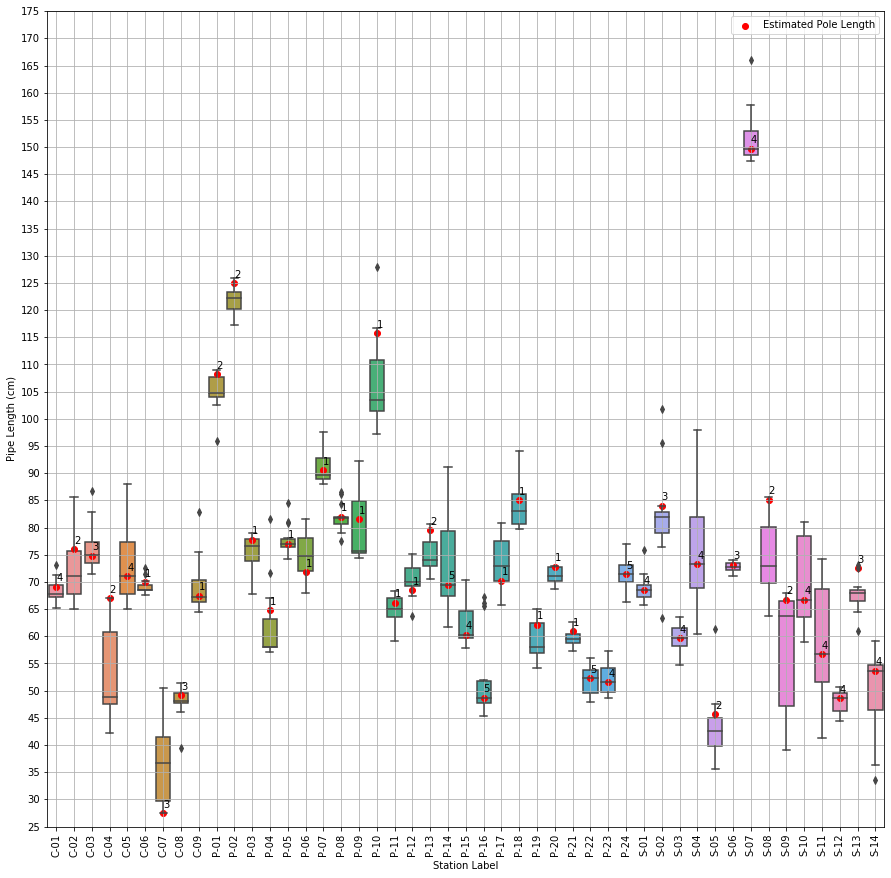

In [265]:
# Elevation estimated from Lidar; maintain precision of relative changes by making pole height a constant elevation
sw_wds = sw_owds.reset_index().rename(columns={'level_0':'moyr'}).set_index(['pntid','moyr']).sort_index()

sw_wds = sw_wds.reset_index()
sw_wds['Date'] = pd.to_datetime(sw_wds['Date'])
#sw_owds = sw_owds.drop(['est_pole_length'],axis=1)

rcParams['figure.figsize'] = 15, 15

plt.scatter(sw_poles.index, sw_poles['est_pole_length'], color='red', label='Estimated Pole Length')

ax = sns.boxplot(x = 'pntid', y='est_pole_length', data=sw_wds)

for t in sw_poles.index:
    plt.text(t,sw_poles.loc[t,'est_pole_length']+1, sw_poles.loc[t,'pole_height_qual'],
             horizontalalignment='left')
#plt.xlabel(sw_owds['pntid'], rotation=90)
plt.xticks(rotation=90)
plt.ylim(25,175)
plt.yticks(range(25,180,5))
plt.ylabel('Pipe Length (cm)')
plt.xlabel('Station Label')
plt.grid()
plt.legend()

One approach to an accurate pole length is to look at only the sites with OWD with 0 and compare the `Top` measurement to the estimated pole length.

Text(0.5, 0, 'Top Measurement (cm)')

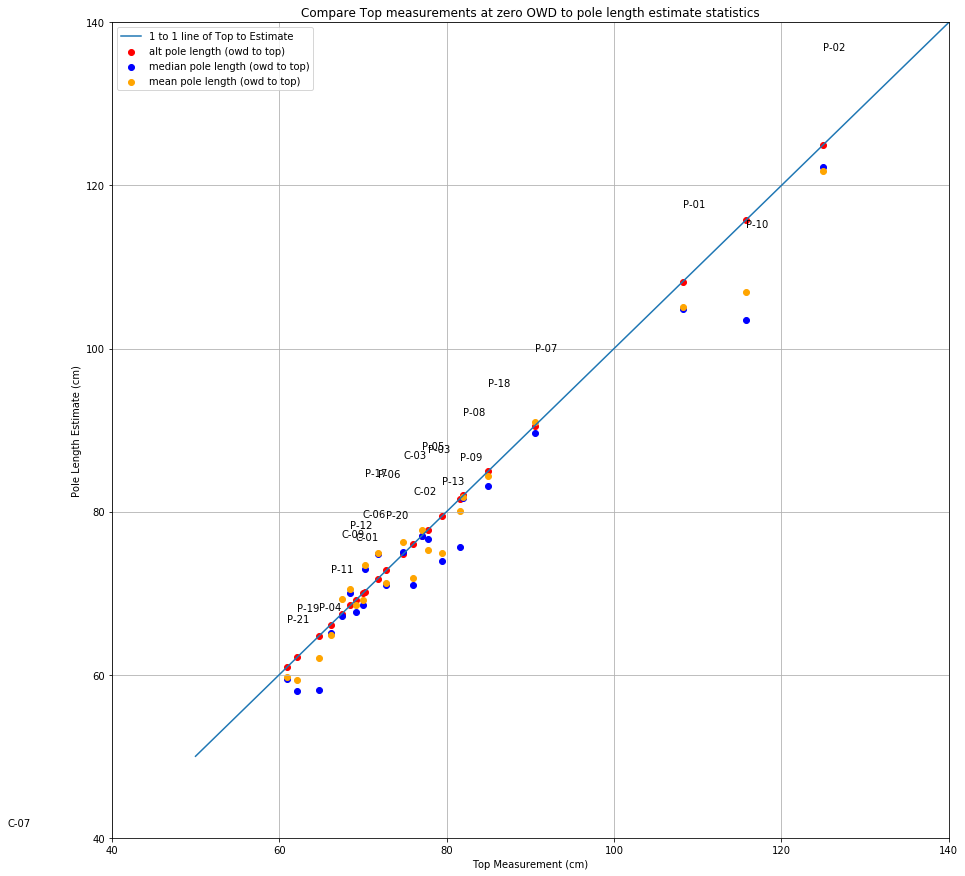

In [266]:
zr_sw = sw_poles[(sw_poles['OWD']==0)]

x = zr_sw['Top']
y = zr_sw['pole_med']
y2 = zr_sw['pole_avg']
y3 = zr_sw['est_pole_length']
txt = zr_sw.index

plt.scatter(x,y3,color='red',label='alt pole length (owd to top)')


plt.scatter(x,y,color='blue',label='median pole length (owd to top)')
plt.scatter(x,y2,color='orange',label='mean pole length (owd to top)')

for t in zr_sw.index:
    plt.text(zr_sw.loc[t,'Top'],zr_sw.loc[t,'pole_med']*1.1+np.random.randint(1,5),t)
x2 = range(50,200)
plt.xlim(40,140)
plt.ylim(40,140)
plt.plot(x2,x2, label = '1 to 1 line of Top to Estimate')
plt.legend()
plt.grid()
plt.title('Compare Top measurements at zero OWD to pole length estimate statistics')
plt.ylabel('Pole Length Estimate (cm)')
plt.xlabel('Top Measurement (cm)')

Derive water level elevation based on pole top elevation and best guesses for pole heights.

Text(0, 0.5, 'Water Elevation (m)')

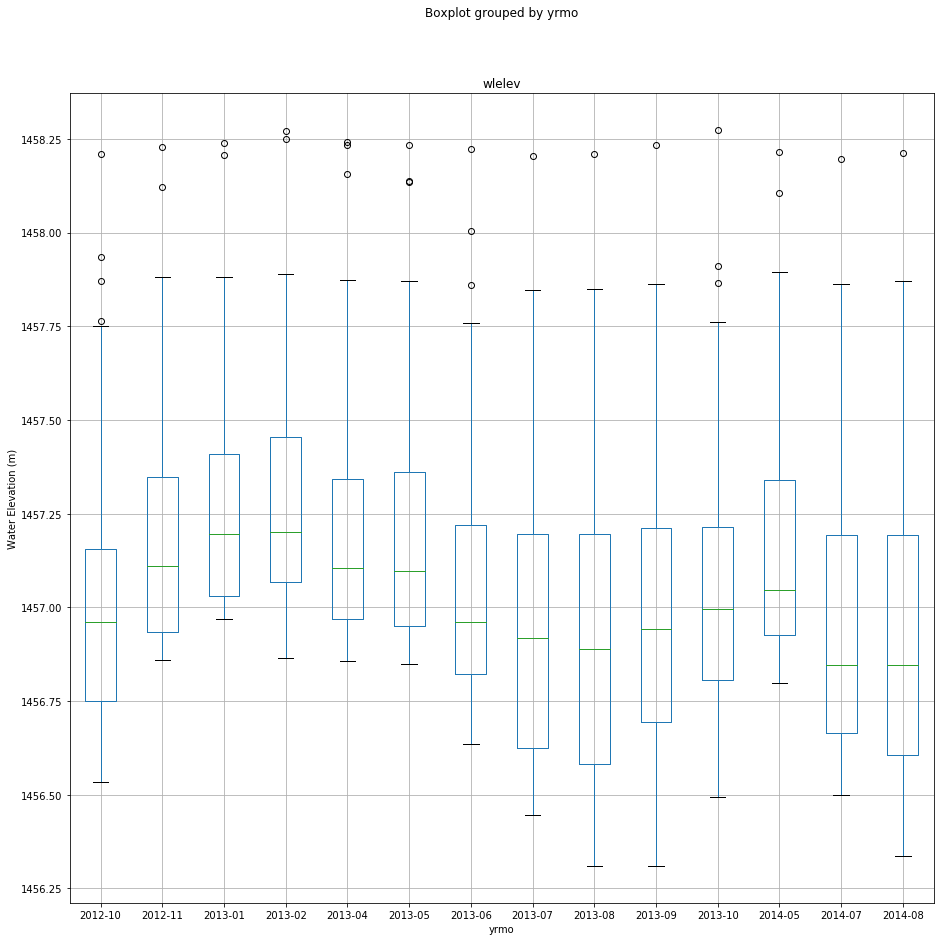

In [267]:
sw_wds['wlelev'] = sw_wds[['pntid','Top']].apply(lambda x: sw_poles.loc[x[0],'pole_top_elev']-x[1]/100,1)
sw_wds['qual'] = sw_wds['pntid'].apply(lambda x: sw_poles.loc[x,'pole_height_qual'],1)
sw_wds['water_bod'] = sw_wds['pntid'].map(water_bods)#.get(x, None),1)
swpos = sw_wds[pd.notna(sw_wds['Date'])]
swpos['yrmo'] = swpos['Date'].apply(lambda x: "{:%Y-%m}".format(x),1)
swpos = swpos.sort_values(['yrmo'])


fig, ax = plt.subplots()

swpos.boxplot(column= ['wlelev'],by = 'yrmo', ax=ax)

ax.set_ylabel('Water Elevation (m)')


In [268]:
sw_wds.head()

pntid       moyr  index                           Site       Point   UTM_X  \
0  C-01  April2013      0  Cattail Marsh - outlet channel  Channel-1  251118   
1  C-01    Aug2013     47  Cattail Marsh - outlet channel  Channel-1  251118   
2  C-01    Aug2014     94  Cattail Marsh - outlet channel  Channel-1  251118   
3  C-01    Feb2013    141  Cattail Marsh - outlet channel  Channel-1  251118   
4  C-01    Jan2013    188  Cattail Marsh - outlet channel  Channel-1  251118   

     UTM_Y  Elevation  VegHeight   TWD  OWD   Top       Date  est_pole_length  \
0  4381854    1457.72   0.283404  24.0  6.0  65.0 2013-04-03             71.0   
1  4381854    1457.72   0.283404  33.0  0.0  69.0 2013-08-21             69.0   
2  4381854    1457.72   0.283404  23.0  1.0  65.7 2014-08-17             66.7   
3  4381854    1457.72   0.283404  34.2  5.0  62.7 2013-02-18             67.7   
4  4381854    1457.72   0.283404  33.0  6.0  61.9 2013-01-04             67.9   

     wlelev  qual      water_bod  
0  1457.760     4  Cattail Marsh  
1  1457.720     4  Cattail Marsh  
2  1457.753     4  Cattail Marsh  
3  1457.783     4  Cattail Marsh  
4  1457.791     4  Cattail Marsh

## Lump Similar Areas

Lump measurement sites into regiemes of similar elevations

In [269]:
reg1 = ['C-02','P-18','P-20','C-06','C-04','C-03','C-09','P-19','P-13',
        'P-11','P-12','P-18','P-21','P-03','P-04','P-20',
        'P-05','P-06','P-07','P-02','P-01','C-01','P-09','P-10','P-17']
reg2 = ['P-01','C-01','P-09','P-10']
reg3 = ['P-02']

In [270]:
sw_wds = sw_wds.set_index(['moyr'])

In [271]:
make_geojson(sw_wds,'waterlevels')

In [290]:
sw_wds['Site '].unique()

array(['Cattail Marsh - outlet channel', 'Scirpus Marsh - outlet channel',
       'SWBM - Channel at S end', 'Channel from Mystery Springs',
       'Chub Haven Marsh - channel from Chub Haven Spring',
       'Main Drain - beginning of ditched area',
       'Channel from Convergence Pond', 'Cowtrap Springs - lower channel',
       'Main Drain - culvert area', 'SWBM - Cattail pool',
       'SWBM - SW lobe', 'SWBM - South pond, West lobe',
       'SWBM - South pond, East lobe', 'SWBM - East edge',
       'Pool SE of Mystery Springs', 'SWBM - NE Pond',
       'Chub Haven Marsh - Open water area', 'SWBM - N lobe',
       'Chub Haven Marsh - fenceline pond', 'Teal Pond - SE cove',
       'Teal Pond, SW cove', 'Teal Pond - NE cove', 'Isosceles Pond',
       'Quagmire Cove', 'Hourglass Pond', 'Big Ephemeral Pond (BEP)',
       'Red Pools', 'Westside Bulrush Marsh',
       'Westside Bulrush Marsh - satellite cove',
       'NE Bulrush Marsh - W lobe', 'Doughnut Pond', 'Convergence Pond',
       

In [280]:
batha['bod_simp'].unique()

array(['Trisulca Spring', 'Tiny spring at Cattail Marsh', 'Tiny Red Pool',
       'Timber Springs', 'Teal Pond', 'Tussock Slough',
       'SW Bulrush Marsh', 'Winter Springs', 'Subway Spring',
       'Springfed marsh draining into Site 6 from other side of fence',
       'Small spring near Site 3', 'Small Ephemeral Pool',
       'Slough Spring', 'Skylight Spring', 'Site 9', 'Site 7', 'Site 6',
       'Site 5', 'Barbell Springs', 'Tussock Spring', 'Lost Springs',
       'Site 11', 'Site 10', 'Mystery Springs', 'Schism Spring',
       'Red pool', 'Red Pond', 'Posthole Spring', 'Pocket Spring',
       'Pocket Red Pool', 'Piezometer Spring & connected pools',
       'Orange Pond', 'NW Bulrush Marsh ', 'NE Bulrush Marsh',
       'Big Ephemeral Pond', 'Main Drain', 'Little Timber Spring',
       'Little Bog Spring', 'Large amoeboid depression', 'Isosceles Pond',
       'Interior channel from Cowtrap Springs', 'Hourglass Pond',
       'Hidden Spring Marsh', 'Gradient Pond', 'Fragmented Red Po

In [296]:
make_geojson(batha.groupby('bod_simp').mean().reset_index(),"bathymetryareas")
make_geojson(sw_wds.groupby('Site ').mean().reset_index(),"swmeasareas")


In [279]:
for bod in batha['bod_simp'].unique():
    if bod in sw_wds['water_bod'].unique():
        print(bod)

Teal Pond
Winter Springs
Site 7
Site 6
Site 5
Barbell Springs
Tussock Spring
Lost Springs
Mystery Springs
Big Ephemeral Pond
Isosceles Pond
Hourglass Pond
Gradient Pond
Cowtrap Springs
Doughnut Pond
Deep Spring
Convergence Pond
Cattail Marsh


# Determining Bathymetric Elevations

In [308]:
joinbath = geopandas.read_file("G:/My Drive/WORK/Leland_Harris/bathymetry.geojson")

In [310]:
joinbath['UTM_XY'] = joinbath[['UTM_X','UTM_Y']].apply(lambda x: str(int(round(x[0],0)))+str(int(round(x[1],0))),1)

In [311]:
batha['UTM_XY'] = batha[['UTM_X','UTM_Y']].apply(lambda x: str(int(round(x[0],0)))+str(int(round(x[1],0))),1)
batha['bath_wl_elev'] = batha['LiDAR_m'] + batha['BathOWD']/100.

In [314]:
joinbath['mean_owd', 'std_owd','theor_elev', 'LiDAR_m',
       'close_theor', 'WaterBody',
       'median_owd', 'geometry', 'UTM_XY']]

Index(['UTM_X', 'UTM_Y', 'OWD', 'TWD', 'FSD', 'theor_elev', 'LiDAR_m',
       'close_theor', 'Water_Body', 'BathDate', 'Notes', 'obsid', 'TARGET_FID',
       'Point.1', 'VegHeight', 'bod_simp', 'April13', 'Aug13', 'Aug14',
       'Feb13', 'Jan13', 'July13', 'July14', 'June13', 'May13', 'May14',
       'Nov12', 'Oct13', 'Oct2012', 'Sept13', 'mean_owd', 'std_owd',
       'median_owd', 'geometry', 'UTM_XY'],
      dtype='object')

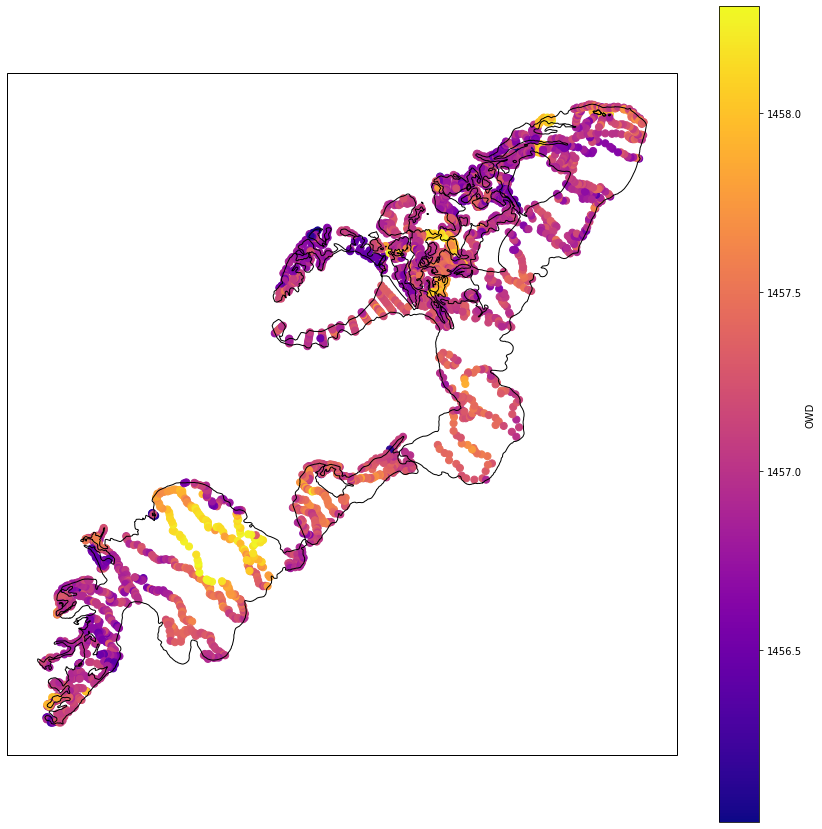

[ 3.78710121e+03  5.35932537e-04 -5.62429745e-04]
[ 3.78710121e+03  5.35932537e-04 -5.62429745e-04]


In [346]:
batha = pd.merge(owdshts, bathsub.reset_index(),on='Ob_ID',how='left')
batha['bath_wl_elev'] = batha['LiDAR_m'] + batha['BathOWD']/100.
belev = batha[batha['BathDate']=='2013-05-02T00:00:00.000000000']
belev = belev.dropna(subset=['UTM_X','UTM_Y','bath_wl_elev'],how='any')
belev = belev[belev['UTM_X']>230000]
belev = belev[(belev['bath_wl_elev']<1458.3)&(belev['bath_wl_elev']>1456)]
easting = belev['UTM_X']*1.0
northing = belev['UTM_Y']*1.0
elevation = belev['bath_wl_elev']
coordinates = (easting, northing)

april2013 = sw_wds.loc['April2013']
easting1 = april2013['UTM_X']*1.0
northing1 = april2013['UTM_Y']*1.0
elevation1 = april2013['Elevation']
coordinates1 = (easting1, northing1)



plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.UTM(12))
plt.scatter(easting, northing,
    c=elevation,
    s=50,
    cmap="plasma",
    transform=ccrs.UTM(12),
)


shape = geopandas.read_file("E:/PROJECTS/Leland_Harris/CSF Analysis/Data/Wetland_Outline.shp")

shape.plot(ax=ax, color='none', edgecolor='black')

plt.colorbar().set_label("OWD")

plt.show()

trend = vd.Trend(degree=1).fit(coordinates, elevation)
print(trend.coef_)

trend1 = vd.Trend(degree=1).fit(coordinates1, elevation1)
print(trend.coef_)

In [319]:
sw_wds

pntid  index                           Site       Point   UTM_X  \
moyr                                                                          
April2013    C-01      0  Cattail Marsh - outlet channel  Channel-1  251118   
Aug2013      C-01     47  Cattail Marsh - outlet channel  Channel-1  251118   
Aug2014      C-01     94  Cattail Marsh - outlet channel  Channel-1  251118   
Feb2013      C-01    141  Cattail Marsh - outlet channel  Channel-1  251118   
Jan2013      C-01    188  Cattail Marsh - outlet channel  Channel-1  251118   
July2013     C-01    235  Cattail Marsh - outlet channel  Channel-1  251118   
July2014     C-01    282  Cattail Marsh - outlet channel  Channel-1  251118   
June2013     C-01    329  Cattail Marsh - outlet channel  Channel-1  251118   
May2013      C-01    376  Cattail Marsh - outlet channel  Channel-1  251118   
May2013bath  C-01    423  Cattail Marsh - outlet channel  Channel-1  251118   
May2014      C-01    470  Cattail Marsh - outlet channel  Channel-1  251118   
Nov2012      C-01    517  Cattail Marsh - outlet channel  Channel-1  251118   
Oct2012      C-01    564  Cattail Marsh - outlet channel  Channel-1  251118   
Oct2013      C-01    611  Cattail Marsh - outlet channel  Channel-1  251118   
Sept2013     C-01    658  Cattail Marsh - outlet channel  Channel-1  251118   
April2013    C-02      1  Scirpus Marsh - outlet channel  Channel-2  251155   
Aug2013      C-02     48  Scirpus Marsh - outlet channel  Channel-2  251155   
Aug2014      C-02     95  Scirpus Marsh - outlet channel  Channel-2  251155   
Feb2013      C-02    142  Scirpus Marsh - outlet channel  Channel-2  251155   
Jan2013      C-02    189  Scirpus Marsh - outlet channel  Channel-2  251155   
July2013     C-02    236  Scirpus Marsh - outlet channel  Channel-2  251155   
July2014     C-02    283  Scirpus Marsh - outlet channel  Channel-2  251155   
June2013     C-02    330  Scirpus Marsh - outlet channel  Channel-2  251155   
May2013      C-02    377  Scirpus Marsh - outlet channel  Channel-2  251155   
May2013bath  C-02    424  Scirpus Marsh - outlet channel  Channel-2  251155   
May2014      C-02    471  Scirpus Marsh - outlet channel  Channel-2  251155   
Nov2012      C-02    518  Scirpus Marsh - outlet channel  Channel-2  251155   
Oct2012      C-02    565  Scirpus Marsh - outlet channel  Channel-2  251155   
Oct2013      C-02    612  Scirpus Marsh - outlet channel  Channel-2  251155   
Sept2013     C-02    659  Scirpus Marsh - outlet channel  Channel-2  251155   
...           ...    ...                             ...        ...     ...   
April2013    S-13     45                 Cowtrap Springs  Spring-13  252001   
Aug2013      S-13     92                 Cowtrap Springs  Spring-13  252001   
Aug2014      S-13    139                 Cowtrap Springs  Spring-13  252001   
Feb2013      S-13    186                 Cowtrap Springs  Spring-13  252001   
Jan2013      S-13    233                 Cowtrap Springs  Spring-13  252001   
July2013     S-13    280                 Cowtrap Springs  Spring-13  252001   
July2014     S-13    327                 Cowtrap Springs  Spring-13  252001   
June2013     S-13    374                 Cowtrap Springs  Spring-13  252001   
May2013      S-13    421                 Cowtrap Springs  Spring-13  252001   
May2013bath  S-13    468                 Cowtrap Springs  Spring-13  252001   
May2014      S-13    515                 Cowtrap Springs  Spring-13  252001   
Nov2012      S-13    562                 Cowtrap Springs  Spring-13  252001   
Oct2012      S-13    609                 Cowtrap Springs  Spring-13  252001   
Oct2013      S-13    656                 Cowtrap Springs  Spring-13  252001   
Sept2013     S-13    703                 Cowtrap Springs  Spring-13  252001   
April2013    S-14     46                     Deep Spring  Spring-14  252131   
Aug2013      S-14     93                     Deep Spring  Spring-14  252131   
Aug2014      S-14    140                     Deep Spring  Spri

In [283]:
wlelevs_by_site = sw_wds.loc['May2013bath'].groupby('pntid').mean().sort_values(['wlelev'])['wlelev'].to_dict()
idmatch = batha[pd.notnull(batha['obsid'])][['Water_Body','obsid']].reset_index().set_index('obsid').to_dict()['Water_Body']
#sw_wds['Water_Body'] = sw_wds['pntid'].map(idmatch)
wlelevs_by_site = sw_wds.loc['May2013bath'].groupby('pntid').mean().sort_values(['wlelev'])['wlelev'].to_dict()
wlelevs_by_body = sw_wds.loc['May2013bath'].groupby('water_bod').mean().sort_values(['wlelev'])['wlelev'].to_dict()

In [284]:
def fixpntid(x):
    if pd.notna(x) and '-' in str(x):
        x1,x2 = x.split('-')
        x = f"{x1}-{x2:0>2}"
    return x
batha['obsid'] = batha['obsid'].apply(lambda x: fixpntid(x),1)

batha['water_elev'] = batha['bod_simp'].map(wlelevs_by_body)
batha['water_elev2'] = batha['obsid'].map(wlelevs_by_site)

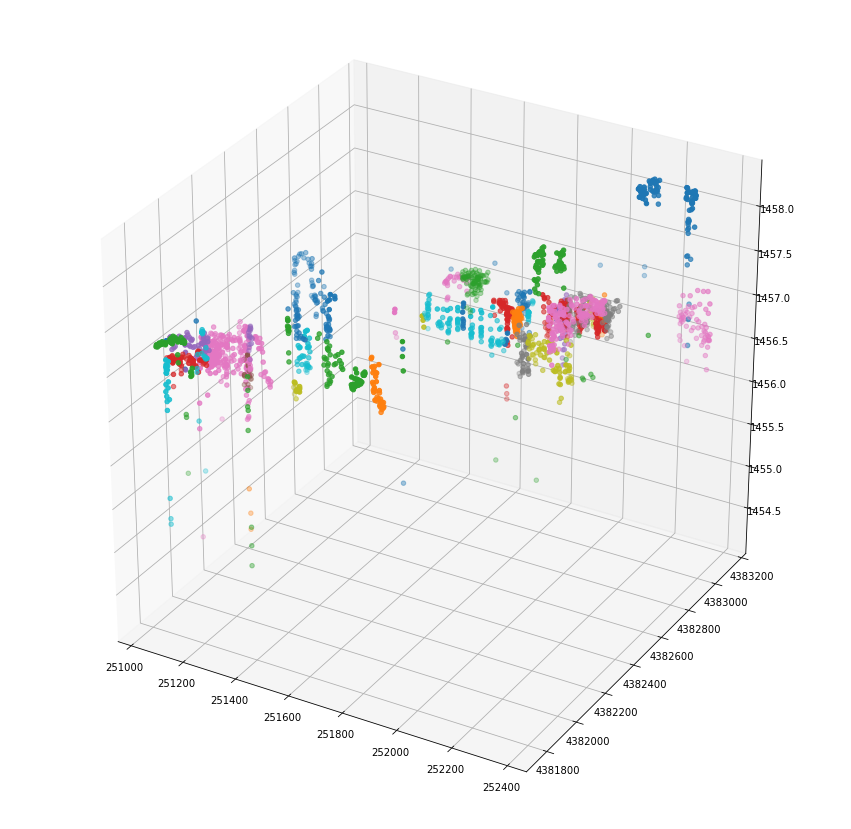

In [35]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for bod in bath['Water_Body'].unique():
    bdf = bath[bath['Water_Body']==bod][['UTM_X','UTM_Y','ground_elev']]
    ax.scatter(bdf.UTM_X, bdf.UTM_Y, bdf.ground_elev, label=bod)
    
plt.show()

In [36]:
sw_wds
wlelevs_by_site = sw_wds.loc['May2013bath'].groupby('Site ').mean().sort_values(['wlelev'])['wlelev'].to_dict()

Interpolate water level elevations from the month of bathymetry measurements.

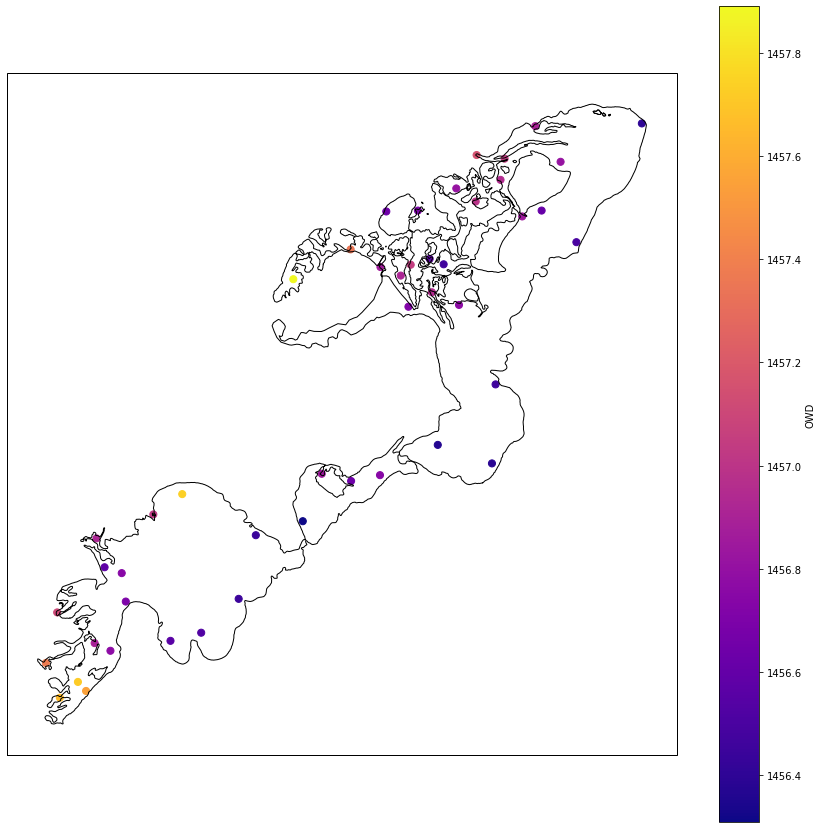

[-2.47706110e+03 -1.35005532e-03  9.75178669e-04]


In [47]:
april2013 = sw_wds.loc['April2013']
easting = april2013['UTM_X']*1.0
northing = april2013['UTM_Y']*1.0
elevation = april2013['Elevation']
coordinates = (easting, northing)

plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.UTM(12))
plt.scatter(easting, northing,
    c=elevation,
    s=50,
    cmap="plasma",
    transform=ccrs.UTM(12),
)

shape = geopandas.read_file("E:/PROJECTS/Leland_Harris/CSF Analysis/Data/Wetland_Outline.shp")

shape.plot(ax=ax, color='none', edgecolor='black')

plt.colorbar().set_label("OWD")

plt.show()

trend = vd.Trend(degree=1).fit(coordinates, elevation)
print(trend.coef_)

In [48]:
trend_values = trend.predict(coordinates)
residuals = elevation - trend_values

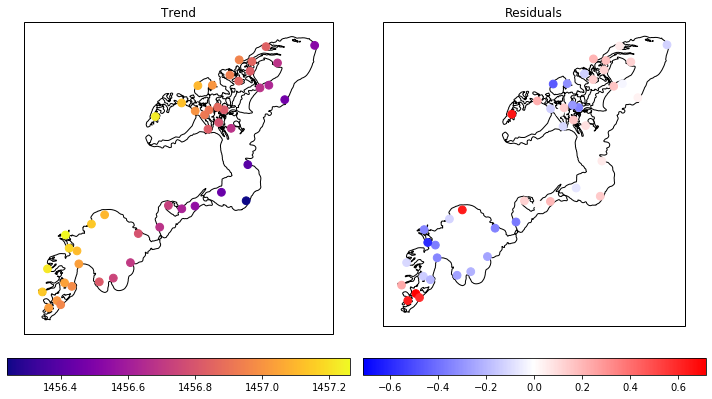

In [49]:
shape = geopandas.read_file("E:/PROJECTS/Leland_Harris/CSF Analysis/Data/Wetland_Outline.shp")

fig, axes = plt.subplots(
    1, 2, figsize=(10, 6), subplot_kw=dict(projection=ccrs.UTM(12))
)

ax = axes[0]
ax.set_title("Trend")
shape = geopandas.read_file("E:/PROJECTS/Leland_Harris/CSF Analysis/Data/Wetland_Outline.shp")
shape.plot(ax=axes[0], color='none', edgecolor='black')
tmp = ax.scatter(
    easting,
    northing,
    c=trend_values,
    s=60,
    cmap="plasma",
    transform=ccrs.UTM(12),
)

plt.colorbar(tmp, ax=ax, orientation="horizontal", pad=0.06)


ax = axes[1]
ax.set_title("Residuals")
maxabs = vd.maxabs(residuals)
shape = geopandas.read_file("E:/PROJECTS/Leland_Harris/CSF Analysis/Data/Wetland_Outline.shp")
shape.plot(ax=axes[1], color='none', edgecolor='black')
tmp = ax.scatter(
    easting,
    northing,
    c=residuals,
    s=60,
    cmap="bwr",
    vmin=-maxabs,
    vmax=maxabs,
    transform=ccrs.UTM(12),
)
plt.colorbar(tmp, ax=ax, orientation="horizontal", pad=0.08)


plt.tight_layout()
plt.show()

In [50]:
reducer = vd.BlockReduce(reduction=np.median, spacing=5 / 60)
print(reducer)

BlockReduce(adjust='spacing', center_coordinates=False,
            reduction=<function median at 0x00000253BA22F048>, region=None,
            shape=None, spacing=0.08333333333333333)


In [349]:
belev.columns

Index(['UTM_X', 'UTM_Y', 'BathOWD', 'OWD', 'BathTWD', 'TWD', 'BathFSD', 'FSD',
       'Point_x', 'BathDate', 'theor_elev', 'LiDAR_m', 'close_theor',
       'Point_y', 'Notes', 'obsid', 'VegHeight', 'bod_simp', 'Water_Body',
       'bath_wl_elev'],
      dtype='object')

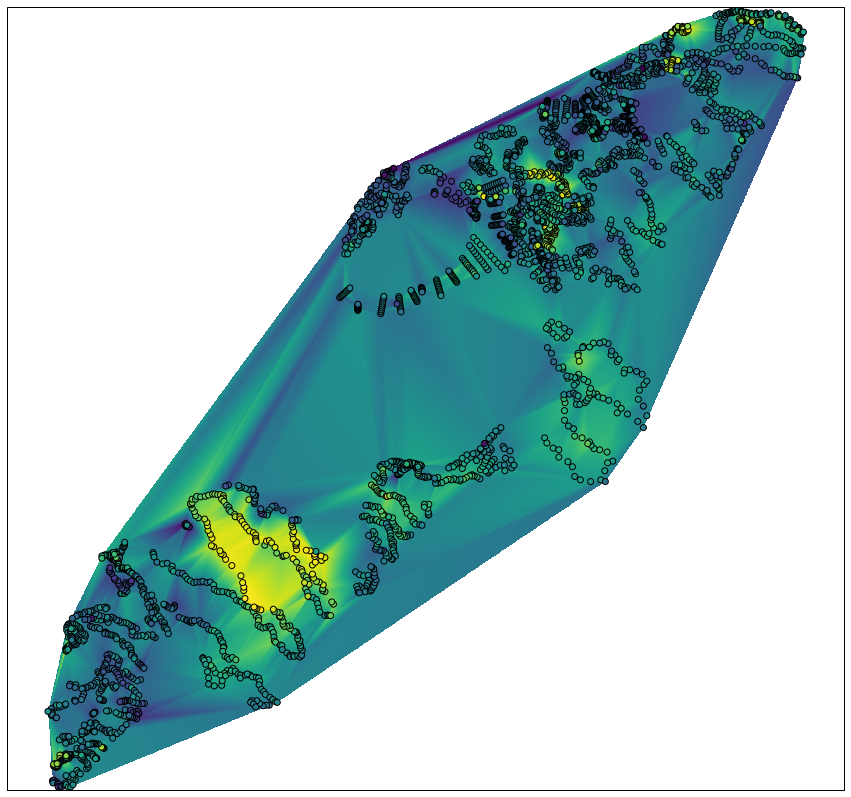

In [352]:
batha = pd.merge(owdshts, bathsub.reset_index(),on='Ob_ID',how='left')
batha['bath_wl_elev'] = batha['LiDAR_m'] + batha['BathOWD']/100.
batha['monthyr'] = batha['BathDate'].apply(lambda x: datetime.datetime.strftime(x,"%Y%m"),1)
batha = batha.set_index(['monthyr','Ob_ID'])
belev = batha[(batha.index.get_level_values(0)=='201305')]
belev = belev.dropna(subset=['UTM_X','UTM_Y','bath_wl_elev'],how='any')
belev = belev[belev['UTM_X']>230000]
belev = belev[(belev['bath_wl_elev']<1458.3)&(belev['bath_wl_elev']>1456)]
month = '201305'

easting = belev['UTM_X']*1.0
northing = belev['UTM_Y']*1.0
elevation = belev['bath_wl_elev']
coordinates = (easting, northing)

april2013 = sw_wds.loc['April2013']
easting1 = april2013['UTM_X']*1.0
northing1 = april2013['UTM_Y']*1.0
elevation1 = april2013['Elevation']
coordinates1 = (easting1, northing1)

df = belev[(belev.index.get_level_values(0)==month)]
dfnona = belev[(belev.index.get_level_values(0)==month)]
dfnona = dfnona.dropna(subset=['UTM_X','UTM_Y','bath_wl_elev'])
dfna = df[pd.isna(df['bath_wl_elev'])]

x = dfnona['UTM_X'].values
y = dfnona['UTM_Y'].values
z = dfnona['bath_wl_elev'].values
x1 = df['UTM_X'].values
y1 = df['UTM_Y'].values
z1 = df['bath_wl_elev'].values
n = df['Water_Body'].values
x3 = dfna['UTM_X'].values
y3 = dfna['UTM_Y'].values

ymin = y1.min()
xmin = x1.min()
xmax = x1.max()
ymax = y1.max()

fig = plt.figure()
proj = cartopy.crs.UTM(12)
ax = plt.axes(projection=proj)
grid_x, grid_y = np.mgrid[xmin:xmax:2000j, ymin:ymax:2000j]
grid_z0 = griddata((x,y),z,(grid_x, grid_y), method='linear')

#cntr = ax.contourf(grid_x,grid_y,grid_z0,transform=proj,cmap='viridis')
cntr = ax.imshow(grid_z0.T, extent=(xmin,xmax,ymin,ymax), origin='lower',transform=proj,cmap='viridis')
ax.scatter(x1, y1, c=z1, cmap='viridis', edgecolors='black')

ax.scatter(x3, y3, facecolors='none', edgecolors='red')

#for i in range(len(n)):
#    ax.annotate(n[i], (x1[i]-3, y1[i]+5), color='orange', 
#                fontproperties = matplotlib.font_manager.FontProperties().set_weight('bold'))

gridspacex = (xmax-xmin)/2000
gridspacey = (ymax-ymin)/2000

def getz(x,y,grid_x,grid_y,grid_z0,gridspacex,gridspacey,xmin,ymin):
    xi = int(round((x-xmin)/gridspacex)-0.5)
    yi = int(round((y-ymin)/gridspacey)-0.5)
    gx = grid_x[xi][0]
    gy = grid_y[yi][0]
    gz = grid_z0[xi,yi]
    return gz

sw_owds['est_elev'] = sw_owds[['UTM_X','UTM_Y']].apply(lambda q: getz(q[0],q[1],grid_x,grid_y,grid_z0,
                                                                 gridspacex,gridspacey,xmin,ymin),1)

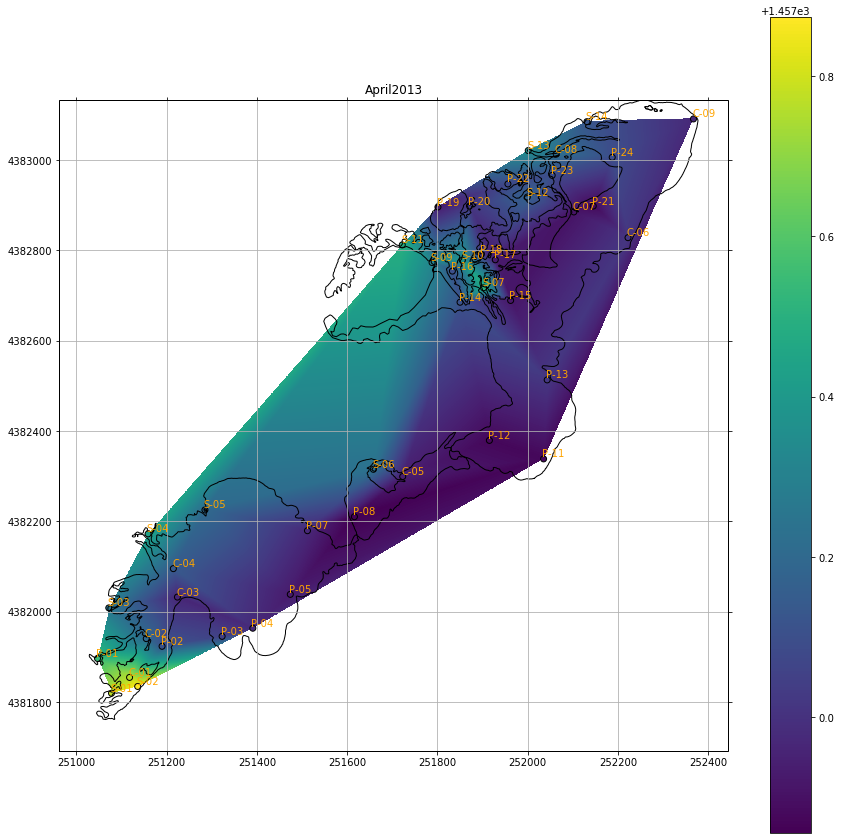

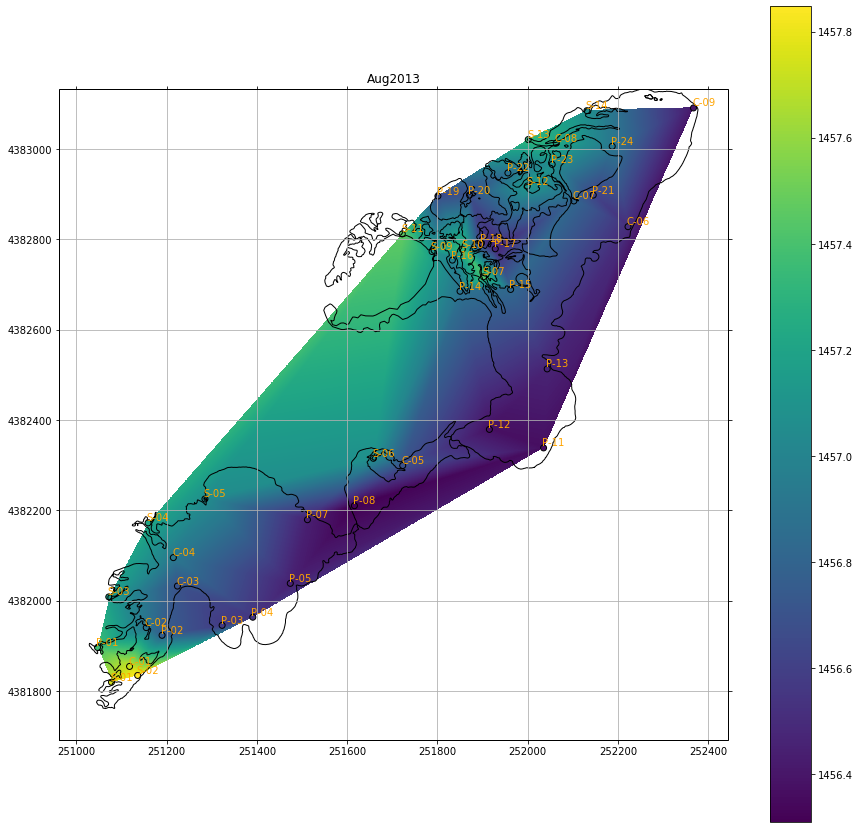

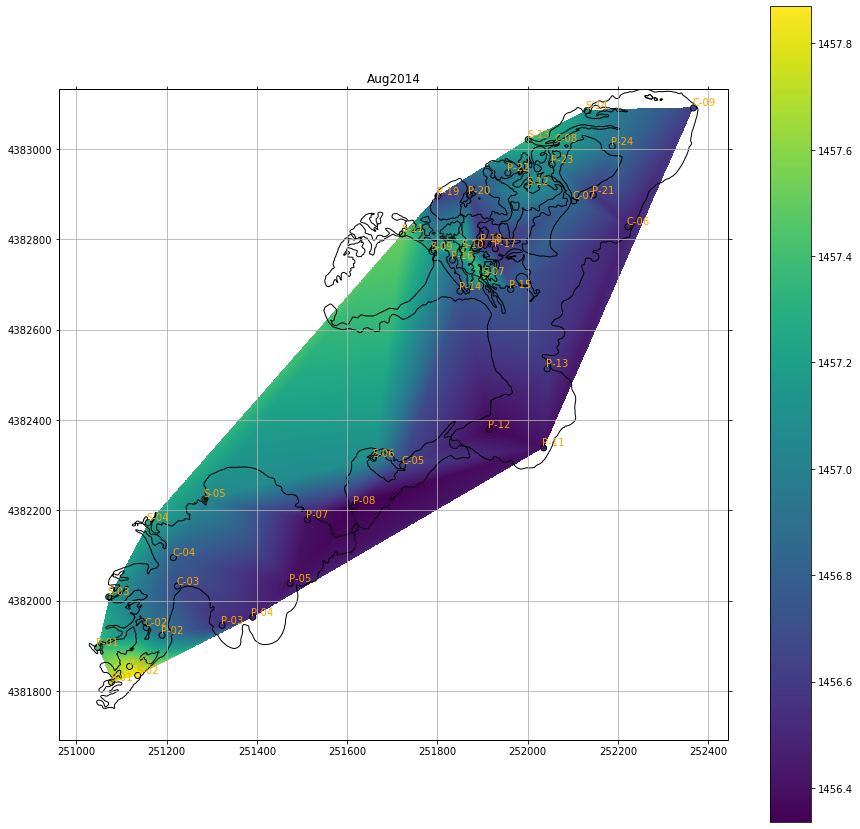

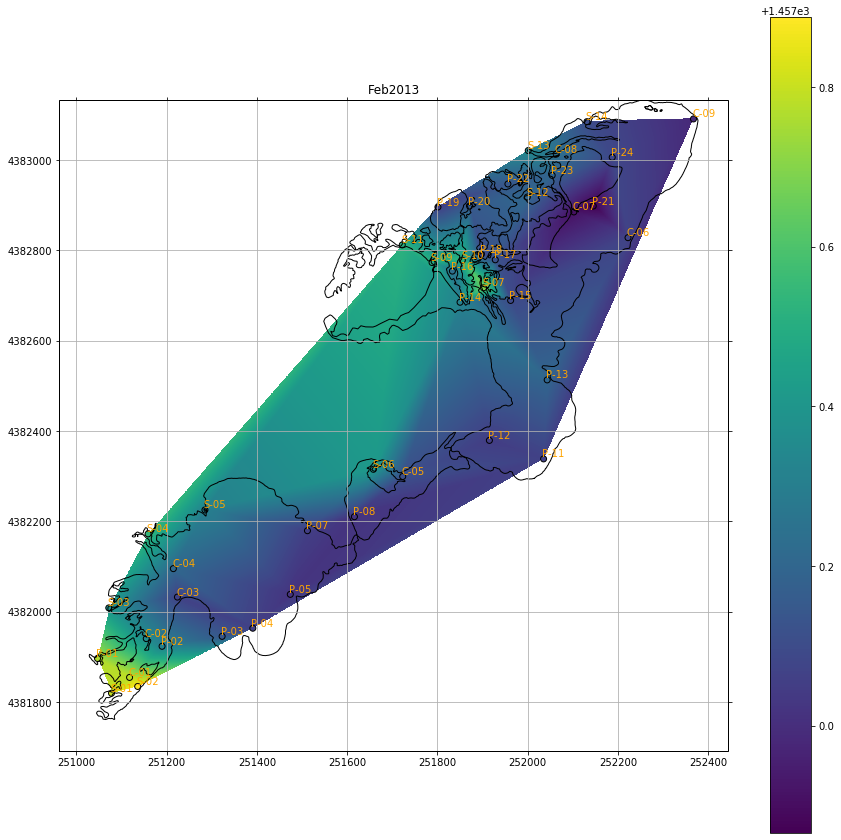

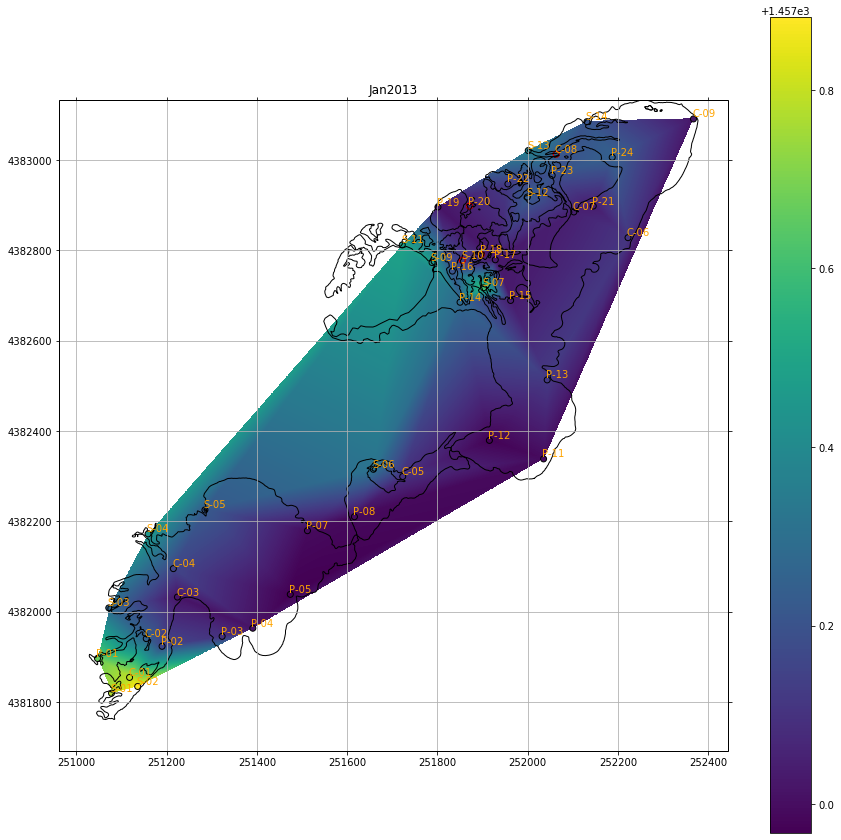

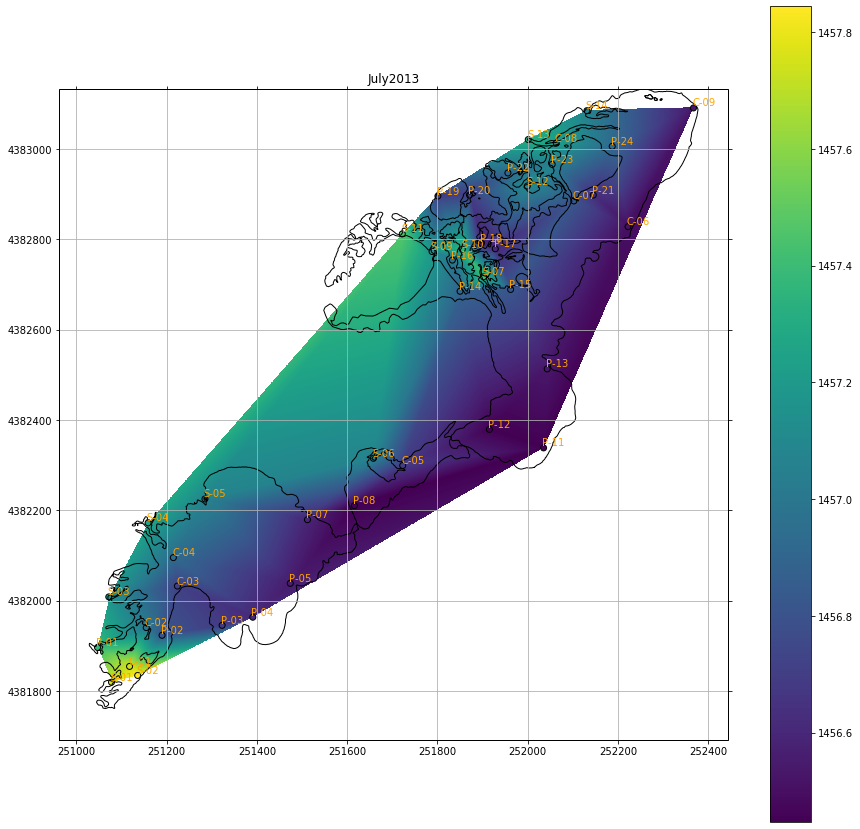

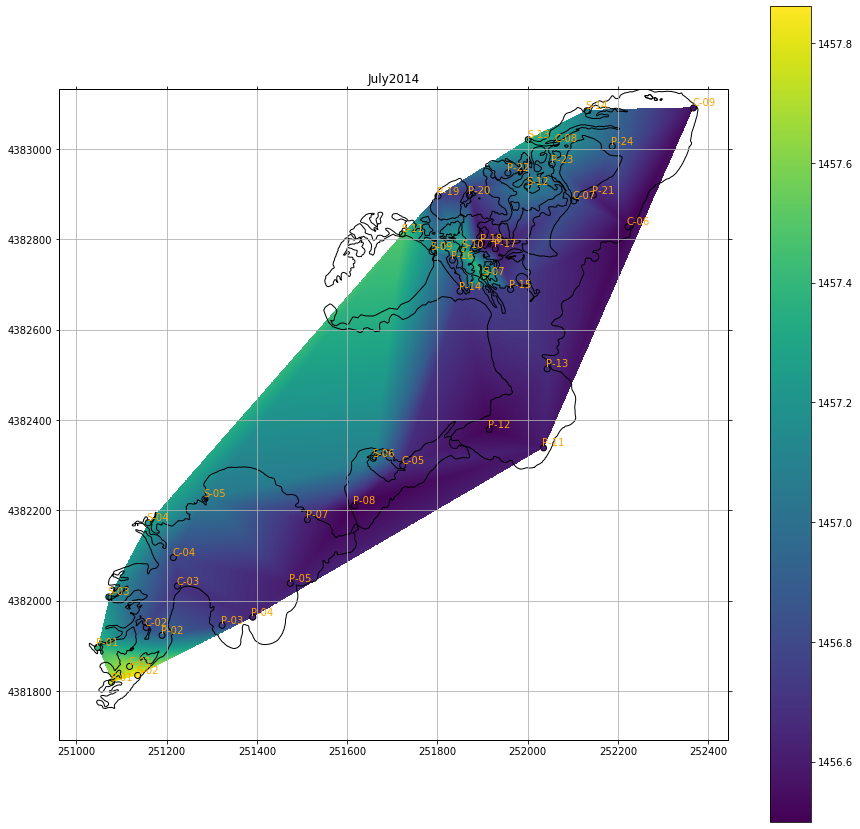

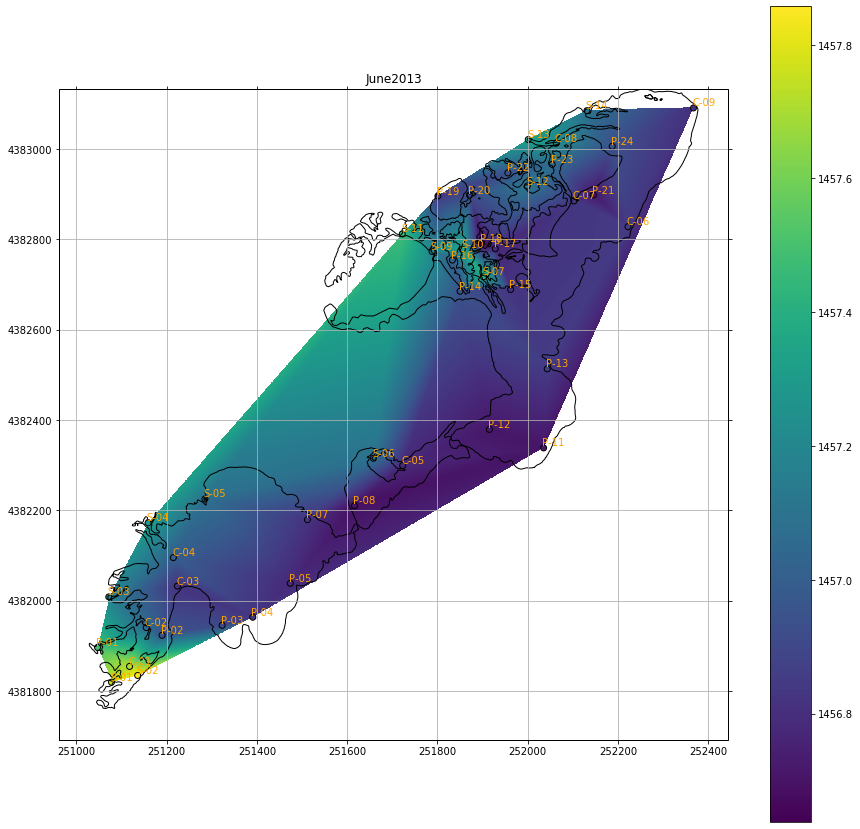

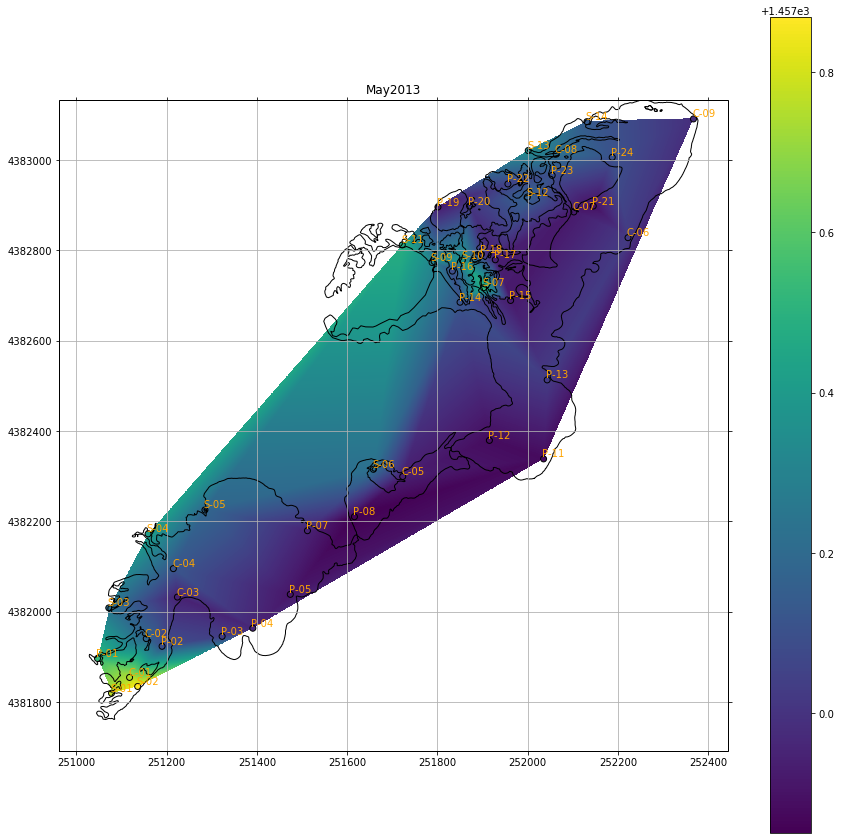

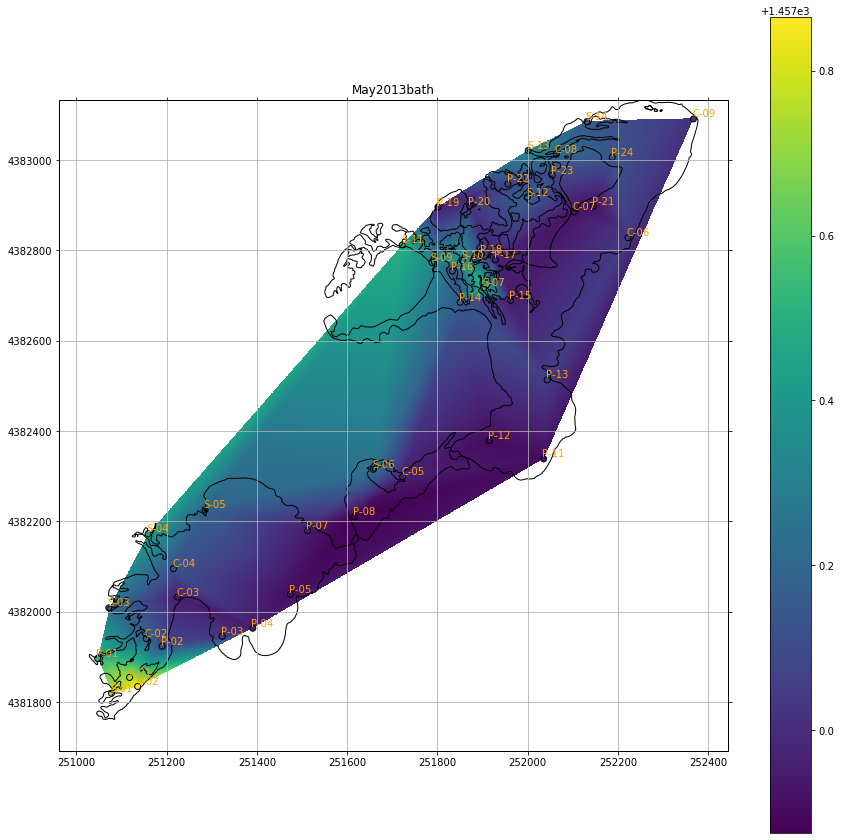

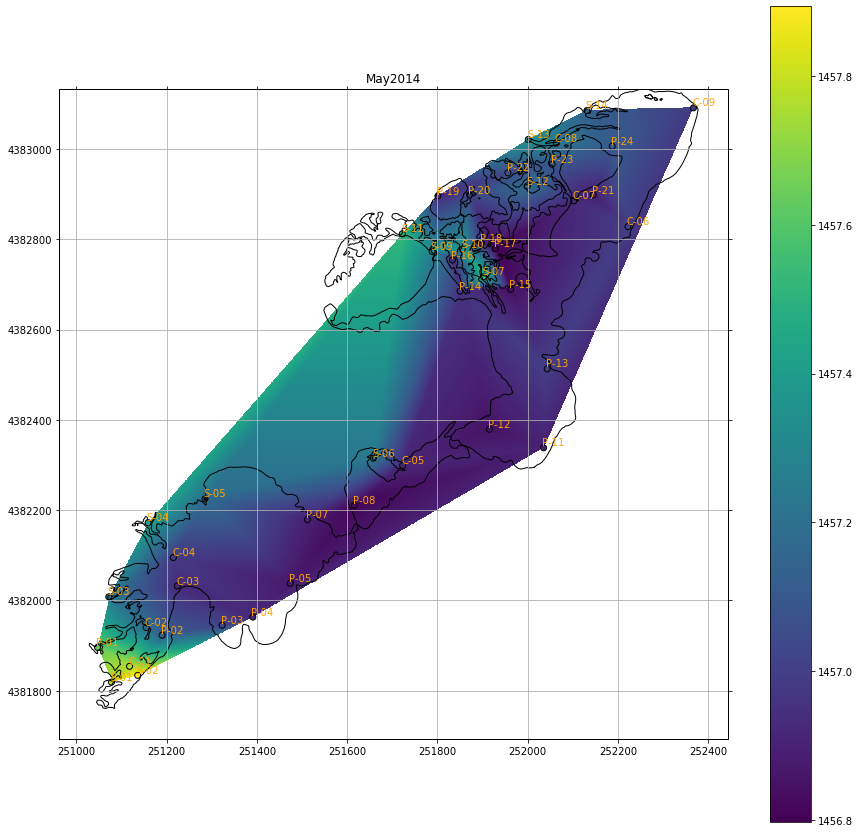

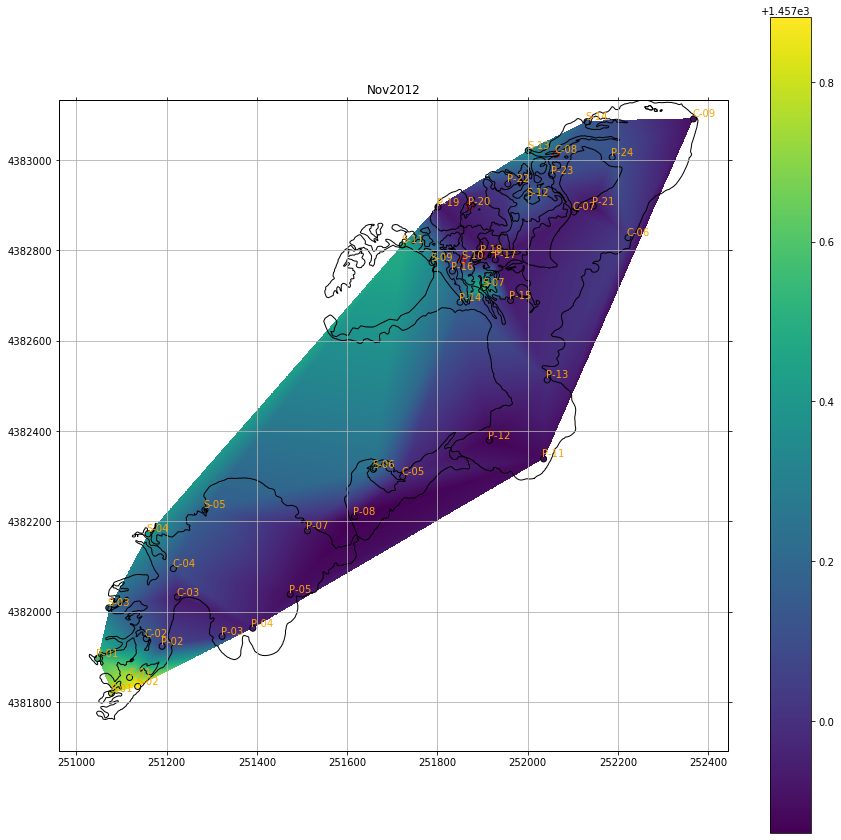

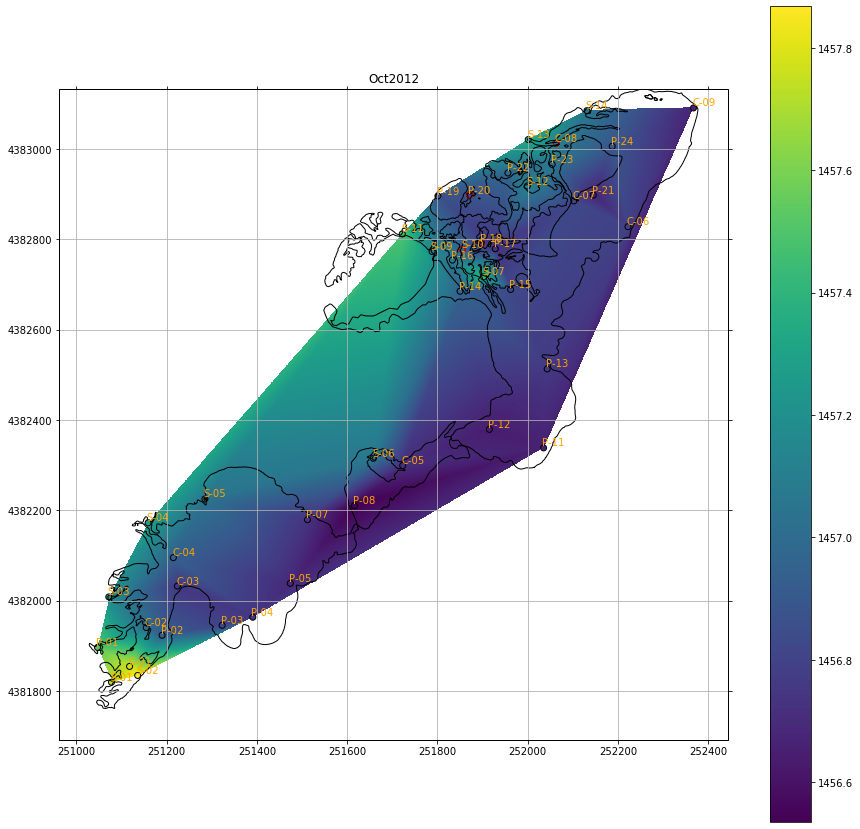

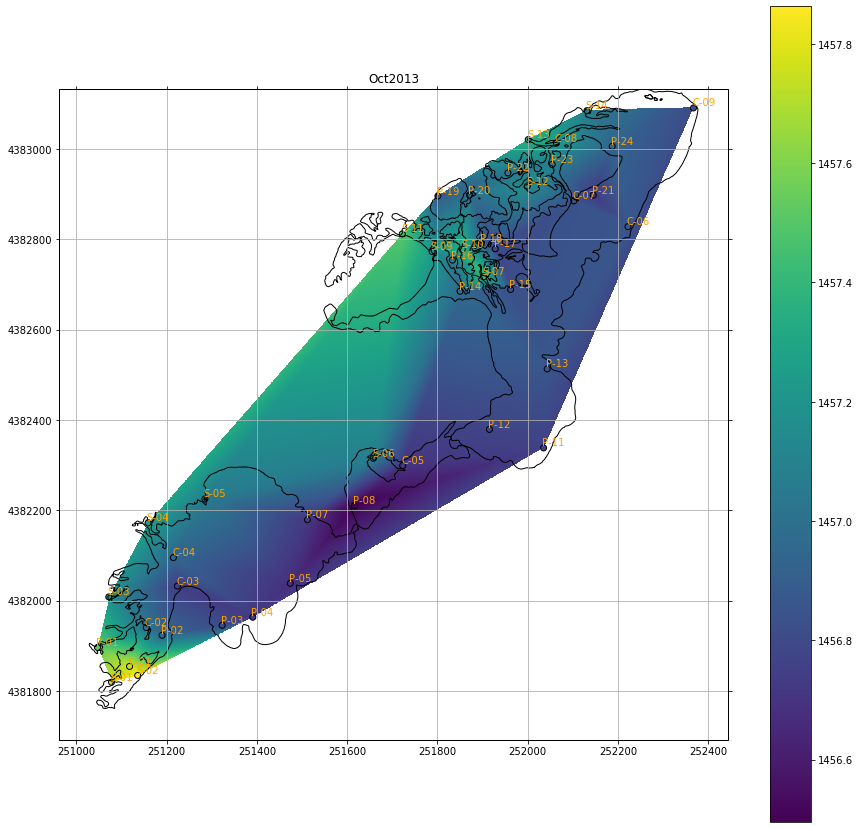

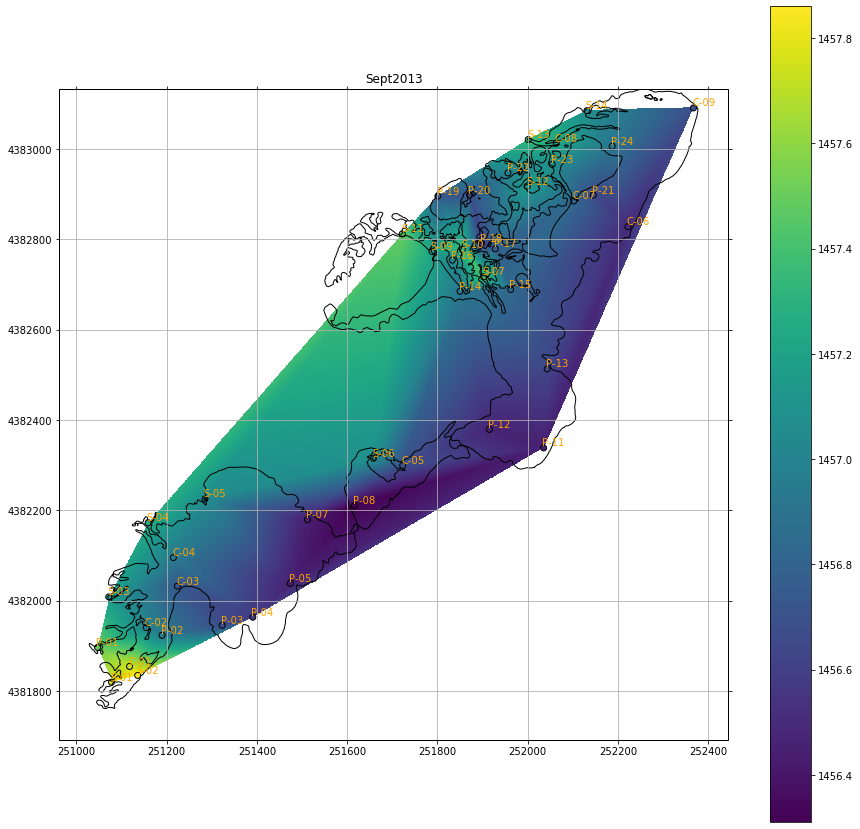

In [51]:

def elev_plotter(sw_owds,month,numcells=2000):

    df = sw_owds[(sw_owds.index.get_level_values(0)==month)]
    dfnona = sw_owds[(sw_owds.index.get_level_values(0)==month)]
    dfnona = dfnona.dropna(subset=['UTM_X','UTM_Y','wlelev'])
    dfna = df[pd.isna(df['wlelev'])]

    x = dfnona['UTM_X'].values
    y = dfnona['UTM_Y'].values
    z = dfnona['wlelev'].values
    x1 = df['UTM_X'].values
    y1 = df['UTM_Y'].values
    z1 = df['wlelev'].values
    n = df['pntid'].values
    x3 = dfna['UTM_X'].values
    y3 = dfna['UTM_Y'].values
    
    ymin = y1.min()
    xmin = x1.min()
    xmax = x1.max()
    ymax = y1.max()
    
    fig = plt.figure()
    proj = cartopy.crs.UTM(12)
    ax = plt.axes(projection=proj)
    grid_x, grid_y = np.mgrid[xmin:xmax:2000j, ymin:ymax:2000j]
    grid_z0 = griddata((x,y),z,(grid_x, grid_y), method='linear')
    
    #cntr = ax.contourf(grid_x,grid_y,grid_z0,transform=proj,cmap='viridis')
    cntr = ax.imshow(grid_z0.T, extent=(xmin,xmax,ymin,ymax), origin='lower',transform=proj,cmap='viridis')
    ax.scatter(x1, y1, c=z1, cmap='viridis', edgecolors='black')

    ax.scatter(x3, y3, facecolors='none', edgecolors='red')
    
    for i in range(len(n)):
        ax.annotate(n[i], (x1[i]-3, y1[i]+5), color='orange', 
                    fontproperties = matplotlib.font_manager.FontProperties().set_weight('bold'))

    gridspacex = (xmax-xmin)/numcells
    gridspacey = (ymax-ymin)/numcells
    
    def getz(x,y,grid_x,grid_y,grid_z0,gridspacex,gridspacey,xmin,ymin):
        xi = int(round((x-xmin)/gridspacex)-0.5)
        yi = int(round((y-ymin)/gridspacey)-0.5)
        gx = grid_x[xi][0]
        gy = grid_y[yi][0]
        gz = grid_z0[xi,yi]
        return gz
        
    df['est_elev'] = df[['UTM_X','UTM_Y']].apply(lambda q: getz(q[0],q[1],grid_x,grid_y,grid_z0,
                                                                     gridspacex,gridspacey,xmin,ymin),1)
    

    plt.title(month)
    plt.grid()
    plt.colorbar(cntr)
    label_utm_grid()
    return fig, ax, df

este = {}

shape = geopandas.read_file("E:/PROJECTS/Leland_Harris/CSF Analysis/Data/Wetland_Outline.shp")

outliers = ['P-09','P-10','S-08','P-06']
subwds = sw_wds[~sw_wds['pntid'].isin(outliers)]

for mo in subwds.index.get_level_values(0).unique():
    fig, ax, este[mo] = elev_plotter(subwds,mo)
    shape.plot(ax=ax, color='none', edgecolor='black')
    

https://gis.stackexchange.com/questions/239198/geopandas-dataframe-to-postgis-table-help

In [55]:

wls_df = pd.concat(este,names=['monthyear'])
wls_df['est_pole_top'] = wls_df['est_elev'] + wls_df['Top']/100.0
elev = wls_df.groupby('pntid').mean()
#elev['est_pole_top'] = elev['est_pole_top'].apply(lambda x: x[0] if pd.isna(x[1]) else x[1],1)
final_elev = elev['est_pole_top'].to_dict()
sw_owds['est_pole_top'] = sw_owds['pntid'].apply(lambda x: final_elev.get(x), 1)
sw_owds['wl_elev2'] = sw_owds['est_pole_top'] - sw_owds['Top']/100.0
sw_owds['elev2'] = sw_owds['est_pole_top'] - sw_owds['Top']/100.0 - sw_owds['OWD']/100.0
sw_owds['wl_elev2_ft'] = sw_owds['wl_elev2']*3.2808
sw_owds['elev2_ft'] = sw_owds['elev2']*3.2808

In [67]:
sw_owds

level_0 pntid                                              Site   \
0    April2013  C-01                     Cattail Marsh - outlet channel   
1    April2013  C-02                     Scirpus Marsh - outlet channel   
2    April2013  C-03                            SWBM - Channel at S end   
3    April2013  C-04                       Channel from Mystery Springs   
4    April2013  C-05  Chub Haven Marsh - channel from Chub Haven Spring   
5    April2013  C-06             Main Drain - beginning of ditched area   
6    April2013  C-07                      Channel from Convergence Pond   
7    April2013  C-08                    Cowtrap Springs - lower channel   
8    April2013  C-09                          Main Drain - culvert area   
9    April2013  P-01                                SWBM - Cattail pool   
10   April2013  P-02                                     SWBM - SW lobe   
11   April2013  P-03                       SWBM - South pond, West lobe   
12   April2013  P-04                       SWBM - South pond, East lobe   
13   April2013  P-05                                   SWBM - East edge   
14   April2013  P-06                         Pool SE of Mystery Springs   
15   April2013  P-07                                     SWBM - NE Pond   
16   April2013  P-08                 Chub Haven Marsh - Open water area   
17   April2013  P-09                                      SWBM - N lobe   
18   April2013  P-10                  Chub Haven Marsh - fenceline pond   
19   April2013  P-11                                Teal Pond - SE cove   
20   April2013  P-12                                 Teal Pond, SW cove   
21   April2013  P-13                                Teal Pond - NE cove   
22   April2013  P-14                                     Isosceles Pond   
23   April2013  P-15                                      Quagmire Cove   
24   April2013  P-16                                     Hourglass Pond   
25   April2013  P-17                           Big Ephemeral Pond (BEP)   
26   April2013  P-18                                          Red Pools   
27   April2013  P-19                             Westside Bulrush Marsh   
28   April2013  P-20            Westside Bulrush Marsh - satellite cove   
29   April2013  P-21                          NE Bulrush Marsh - W lobe   
..         ...   ...                                                ...   
675   Sept2013  P-09                                      SWBM - N lobe   
676   Sept2013  P-10                  Chub Haven Marsh - fenceline pond   
677   Sept2013  P-11                                Teal Pond - SE cove   
678   Sept2013  P-12                                 Teal Pond, SW cove   
679   Sept2013  P-13                                Teal Pond - NE cove   
680   Sept2013  P-14                                     Isosceles Pond   
681   Sept2013  P-15                                      Quagmire Cove   
682   Sept2013  P-16                                     Hourglass Pond   
683   Sept2013  P-17                           Big Ephemeral Pond (BEP)   
684   Sept2013  P-18                                          Red Pools   
685   Sept2013  P-19                             Westside Bulrush Marsh   
686   Sept2013  P-20            Westside Bulrush Marsh - satellite cove   
687   Sept2013  P-21                          NE Bulrush Marsh - W lobe   
688   Sept2013  P-22                                      Doughnut Pond   
689   Sept2013  P-23                                   Convergence Pond   
690   Sept2013  P-24                                    Phragmites Cove   
691   Sept2013  S-01                           Barbell Springs (Site 4)   
692   Sept2013  S-02                       Cattail Marsh - Lemna Spring   
693   Sept2013  S-03                            Tussock Spring (Site 3)   
694   Sept2013  S-04                           Mystery Springs (Site 2)   
695   Sept2013  S-05                            Pothole Spring (Site 5)   
696   Sept2013  S-06            

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning:

indexing past lexsort depth may impact performance.



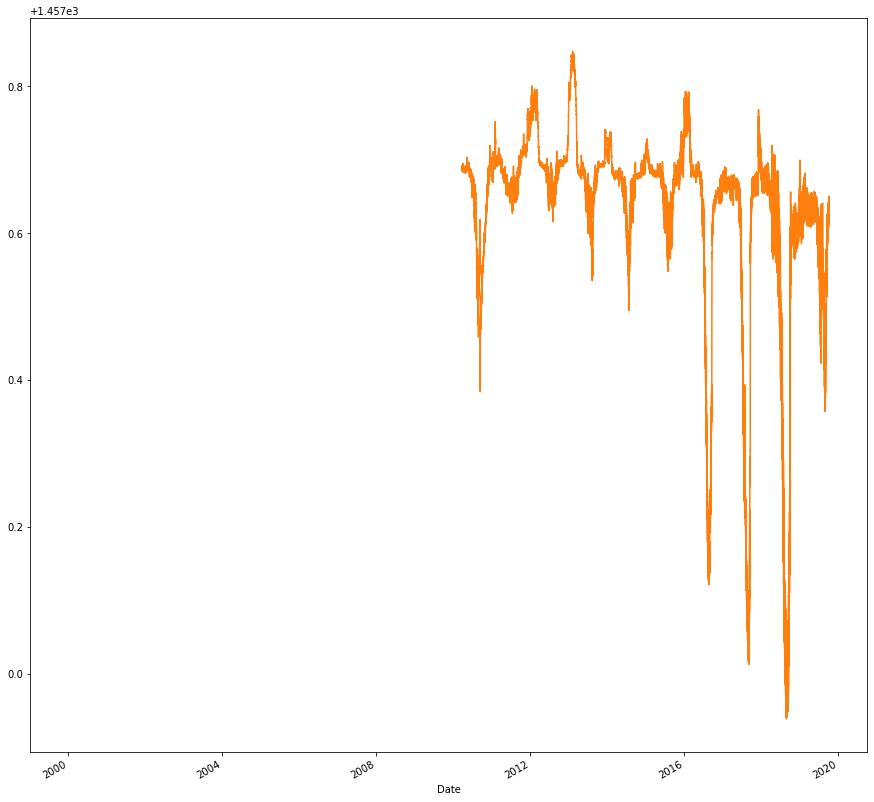

In [69]:
sw_owds.set_index(['pntid','Date']).loc['S-08','wl_elev2'].plot()
file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
y = wls_piv['1011_wle']/3.2808
x = wls_piv.index
plt.plot(x,y)

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\l

Text(0.5, 1.0, 'SW Bulrush Marsh')

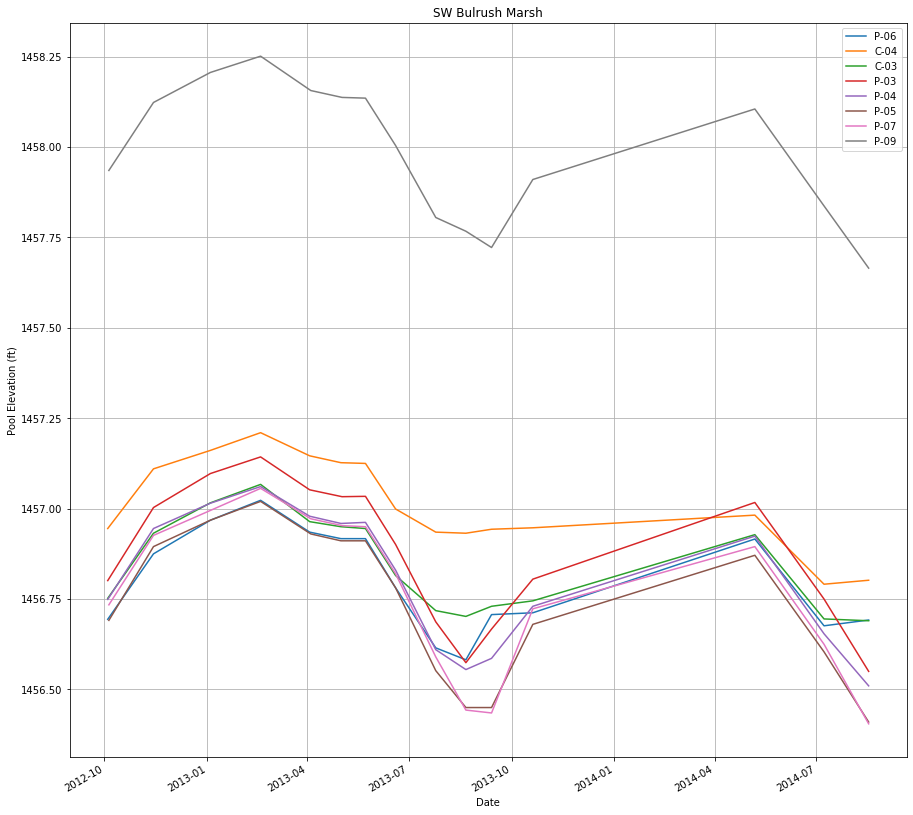

In [56]:
sw_bulrush_marsh = ['P-06','C-04','C-03','P-03','P-04','P-05','P-07','P-09']
for i in sw_bulrush_marsh:
    sw_wds.set_index(['pntid','Date']).loc[i,'wlelev'].plot(label=i)
plt.legend()
plt.grid()
plt.ylabel('Pool Elevation (ft)')
plt.title('SW Bulrush Marsh')

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning:

indexing past lexsort depth may impact performance.



Text(0.5, 1.0, 'Cattail Marsh')

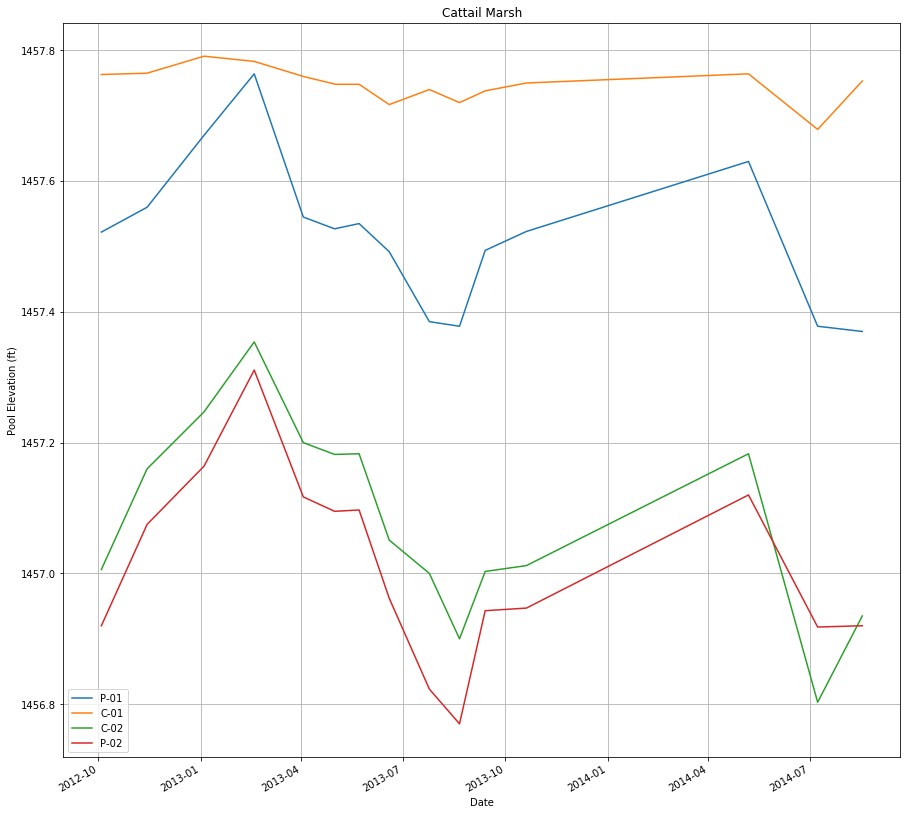

In [57]:
cattail_marsh = ['P-01','C-01','C-02','P-02']
for i in cattail_marsh:
    sw_wds.set_index(['pntid','Date']).loc[i,'wlelev'].plot(label=i)
plt.legend()
plt.grid()
plt.ylabel('Pool Elevation (ft)')
plt.title('Cattail Marsh')

In [58]:
rcParams['figure.figsize'] = 15, 15
sw_elev.T.plot()

NameError: name 'sw_elev' is not defined

In [59]:
for ind in sw_owds.index.get_level_values(0):
    sw_owds.loc[ind,'est_length'].plot()


KeyError: 'the label [est_length] is not in the [index]'

In [ ]:
P = np.array( owd[['UTM_X','UTM_Y','OWD']] )
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
cmap = 'viridis'
sc = ax.scatter( owd['UTM_X']/1000, owd['UTM_Y']/1000, c=owd['OWD'], s=64,cmap=cmap)
ax.set_aspect(1)
#plt.xlim(-2,22)
#plt.ylim(-2,17.5)

plt.xlabel('UTM_X')
plt.ylabel('UTM_Y')
th=plt.title('Elevation')

plt.colorbar(sc)

In [ ]:
owd['OWD'].describe()

In [ ]:
hrange = (0,350)
z = owd[owd['OWD'] > 0]['OWD']

mu, std = scipy.stats.norm.fit(z)
ahist=plt.hist(z, bins=15, density=True, alpha=0.6, color='c')#,range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.lognorm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
th=plt.title(title)
xh=plt.xlabel('Depth')
yh=plt.ylabel('Density')
plt.xscale('log')
#xl=plt.xlim(11.5,17.5)
#yl=plt.ylim(-0.02,0.45)

# Compare Piezometer Data to Grover Data

## Import Piezomter Data

In [38]:
well_table = ll.pull_well_table(engine2)

lh_sites = well_table[well_table.index.isin([
    61, 62, 63, 64, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
    1061, 1064, 1066, 1068, 1069
])]

In [40]:
sql = """SELECT locationid, locationname, locationtype, locationdesc, 
    altlocationid, verticalmeasure, verticalunit, welldepth, siteid, stickup,
    loggertype, the_geom
    FROM monitoringlocations
    WHERE altlocationid IN(61, 62, 63, 64, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
    1061, 1064, 1066, 1068, 1069)
    ORDER BY altlocationid ASC;"""
savedir = "G:/My Drive/WORK/Leland_Harris/"
piez_gdf = geopandas.GeoDataFrame.from_postgis(sql, engine, geom_col='the_geom' )


In [41]:
piez_gdf.to_file(savedir+'piezometers.geojson', driver='GeoJSON')

In [44]:
piez_gdf.to_file(savedir + "leland.gpkg", layer='piezometers', driver="GPKG")

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_piezometers_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_piezometers_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


In [45]:
lh_sites.head()

locationid locationname locationtype  \
altlocationid                                              
61             393331113533001        SG25A         Well   
62             393331113533002        SG25B         Well   
63             393331113533003        SG25C         Well   
64             393331113534401        SG25D         Well   
1011           393329113532901        P1011         Well   

                       locationdesc  verticalmeasure verticalunit  welldepth  \
altlocationid                                                                  
61                             None         4789.000           ft       25.0   
62                             None         4789.000           ft       65.0   
63                             None         4789.100           ft      116.0   
64                             None         4795.100           ft       60.0   
1011           Leland-Harris - 1011         4783.196           ft        4.1   

               siteid  stickup                               loggertype  \
altlocationid                                                             
61               25.0     2.10  Global Water until 6/8/10, then Solinst   
62               25.0     2.22  Global Water until 6/8/10, then Solinst   
63               25.0     2.16  Global Water until 6/8/10, then Solinst   
64               25.0     2.32  Global Water until 6/8/10, then Solinst   
1011             59.0     1.02                                     None   

               baroefficiency   latitude   longitude baroefficiencystart  \
altlocationid                                                              
61                        0.0  39.558605 -113.891770                 NaT   
62                        0.0  39.558710 -113.891670                 NaT   
63                        0.1  39.558666 -113.891720          2009-12-03   
64                        0.0  39.558600 -113.895670                 NaT   
1011                      0.0  39.558103 -113.891314                 NaT   

              barologgertype  
altlocationid                 
61                      9025  
62                      9025  
63                      9025  
64                      9025  
1011                    9025

In [43]:
def make_geojson(df, name, xcord='UTM_X', ycord='UTM_Y', 
                 epsg = '26912', savedir = "G:/My Drive/WORK/Leland_Harris/"):
    crs = {'init': 'epsg:{:}'.format(epsg)}
    geometry = [Point(xy) for xy in zip(df[xcord], df[ycord])]
    gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)
    gdf.to_file(savedir + "{:}.geojson".format(name), driver='GeoJSON')

In [ ]:
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")

In [ ]:
make_geojson(lh_sites, 'piezometers', xcord='longitude',ycord='latitude',epsg=)

In [ ]:
lh_sites.columns